In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
import copy
import random
import astroalign as aa
import pickle
import seaborn as sns
import os.path
import jakeGloess as jg
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, join, MaskedColumn, vstack
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.time import Time
from astropy.io.votable import parse, parse_single_table
from astroquery.irsa_dust import IrsaDust
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

### Functions:

In [2]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/PAL5/'+savename, dpi=500)
    
    #plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, std, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

def make_catalog(x, y, header):
    crd = np.transpose((x, y))
    w = wcs.WCS(header)
    world = w.wcs_pix2world(crd, 0)
    ra = world[:,0]
    dec = world[:,1]
    cat = SkyCoord(ra, dec, frame='icrs', unit='deg')
    
    return cat, ra, dec

### Initial conditions:

In [5]:
run_all = True  # set to False to run only the first epoch
cluster = 'PAL5'
base_dir = 'data/'+cluster+'/'
#channel = '3p6um'
channel = '4p5um'
#method = 'aperture'
method = 'PSF'
model_epoch = 'master'  # ePSF model epoch to use (loads from file now for ease)

sigma_level = 6.
#sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
#sharphi = 0.9
sharphi = 1.
sharphi_PSF = 0.85
sharphi_model = 0.7
#sharplo = 0.65
star_r = 20   # defines the bounds of the region around the known RRL location

if cluster == 'PAL5':
    ch1_list = [0, 2, 4, 5]
    ch2_list = [0, 1, 2, 3, 4, 5, 6]
    
if cluster == 'PAL13':
    ch1_list = [0, 1, 2, 4]
    ch2_list = [0, 1, 2, 3]

if channel == '3p6um':
    zmag       = 18.80           # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02           # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233         # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  apcorr * 0.02  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
    starlist = ch1_list
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  apcorr * 0.02
    starlist = ch2_list
else:
    print('Please select a valid channel')



### Generate master source list:

Current star: RRL1
Star's pixel coordinates: (414.99420081478496, 532.6149408007268)


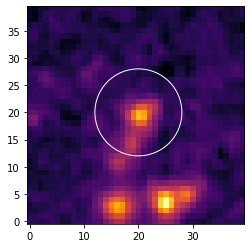

Number of PSF stars: 3


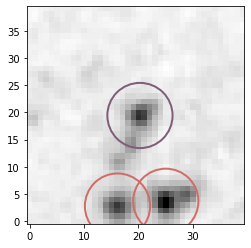

Time taken to fit PSF model: 0.04788250000001426s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA        dec    
--------- --------- --------- --- ... --------- --------- --------- -----------
16.157575 2.7609621  40078.39   1 ... 411.15178  515.3759 228.99119 -0.11464486
25.039755 3.6411789 61942.051   2 ... 420.03396 516.25612  228.9908 -0.11608117
20.289235 19.423976  41310.73   3 ... 415.28344 532.03892 228.98834 -0.11486885
29.606008 5.3802133 10372.962   1 ... 424.60021 517.99515 228.99039 -0.11678441



Current star: RRL2
Star's pixel coordinates: (855.9049510884745, 439.8232767015786)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


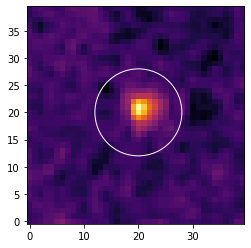

Number of PSF stars: 3


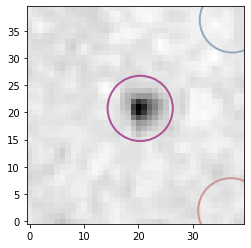

Time taken to fit PSF model: 0.038316499999837106s
   x_0       y_0      flux_0    id ...   x_true    y_true      RA        dec    
--------- --------- ---------- --- ... --------- --------- --------- -----------
36.990682 1.8997851 -146.06572   1 ... 872.89563 421.72306 228.99397 -0.19312144
20.331909 20.728731  38726.963   2 ... 856.23686 440.55201 228.99133 -0.18986799
37.285987 37.003913 -2484.8341   3 ... 873.19094 456.82719 228.98819 -0.19221077



Current star: RRL3
Star's pixel coordinates: (663.514197199275, 96.47851241810335)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


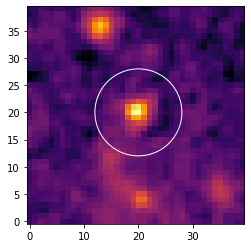

Number of PSF stars: 3


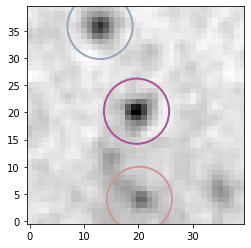

Time taken to fit PSF model: 0.04078129999993507s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA        dec    
--------- --------- --------- --- ... --------- --------- --------- -----------
20.187335 3.9986989 27971.126   1 ... 663.70153 80.477211 229.05579 -0.16805136
19.655275 20.208865 35463.946   2 ... 663.16947 96.687377 229.05314 -0.16752095
12.940712  35.81612 23789.756   3 ... 656.45491 112.29463 229.05076 -0.16599051



Current star: RRL4
Star's pixel coordinates: (806.1803977396282, 249.40389799916073)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


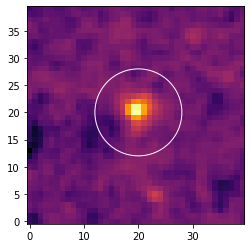

Number of PSF stars: 1


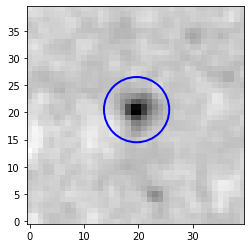

Time taken to fit PSF model: 0.040944800000033865s
   x_0       y_0      flux_0    id ...   x_true    y_true      RA        dec    
--------- --------- ---------- --- ... --------- --------- --------- -----------
 19.67092 20.501484  31299.805   1 ... 805.85132 249.90538 229.02405  -0.1867933
18.429433 20.516267 -2028.5725   1 ... 804.60983 249.92016 229.02408 -0.18658878



Current star: RRL5
Star's pixel coordinates: (302.3455206148508, 524.7273141714124)


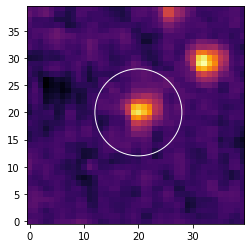

Number of PSF stars: 2


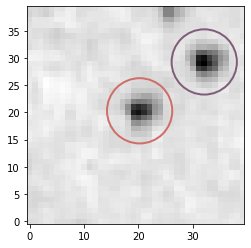

Time taken to fit PSF model: 0.046443100000033155s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA        dec     
--------- --------- --------- --- ... --------- --------- --------- ------------
20.231591 20.286052 37759.095   1 ... 302.57711 525.01337 228.99257  -0.09653026
32.115161 29.274202 40783.702   2 ... 314.46068 534.00152 228.99077  -0.09823849
 25.77957 38.061387 7862.0149   1 ... 308.12509  542.7887  228.9895 -0.096956716



Current star: RRL6
Star's pixel coordinates: (258.9076629579172, 509.29044391184834)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


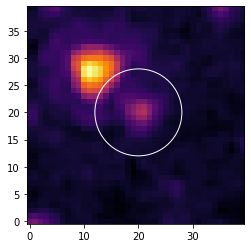

Number of PSF stars: 3


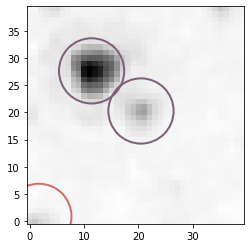

Time taken to fit PSF model: 0.039210800000091695s
   x_0       y_0       flux_0   id ...   y_true      RA        dec     
--------- ---------- --------- --- ... --------- --------- ------------
1.6913981 0.86866289 8015.7306   1 ... 490.15911       229 -0.087292566
20.479184  20.254612 66960.812   2 ... 509.54506  228.9963 -0.089851827
11.394109  27.633949 1094209.4   3 ... 516.92439 228.99533 -0.088156468



Current star: RRL7
Star's pixel coordinates: (1301.2495210348716, 72.76167957563291)


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


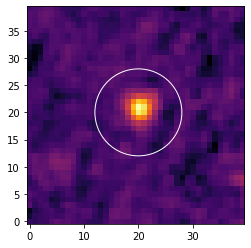

Number of PSF stars: 2


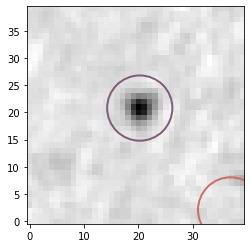

Time taken to fit PSF model: 0.0337509000000864s
   x_0       y_0      flux_0   id ...   x_true    y_true      RA        dec    
--------- --------- --------- --- ... --------- --------- --------- -----------
36.973308 2.0552884 940.40091   1 ... 1318.2228 54.816968 229.04213 -0.27636541
20.254074 20.788959 40272.169   2 ... 1301.5036 73.550638  229.0395 -0.27310464





C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


In [6]:
epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

master_file = base_dir+cluster+'/'+cluster+'_'+channel+'.fits'
with fits.open(master_file) as hdu_list:
    image_m = hdu_list[0].data
    hdr_m = hdu_list[0].header
    exptime = hdr_m['EXPTIME']
    if cluster == 'PAL13' and channel == '4p5um':
        fluxconv = 0.1469
    else:
        fluxconv = hdr_m['FLUXCONV']
    conv = exptime / fluxconv
    data_m = image_m * conv
    w = wcs.WCS(hdr_m)

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        print('Current star: RRL{}'.format(star+1))
    
        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        pix_crd = w.world_to_pixel(star_crd)
        print("Star's pixel coordinates: ({0}, {1})".format(pix_crd[0], pix_crd[1]))

        star_x = int(pix_crd[0])
        star_y = int(pix_crd[1])
        star_ap = CircularAperture((star_r, star_r), r=8.)
        region_m = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
        plt.imshow(region_m, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
        star_ap.plot(color='white')
        plt.show()

        mean, median, std = sigma_clipped_stats(region_m, sigma=sigma_level)
        #print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

        ###   DETECTING MORE STARS   ###

        sources_m = star_find(region_m, sigma_level, FWHM, std, roundness, sharphi_PSF)
        pos_m = np.transpose((sources_m['xcentroid'], sources_m['ycentroid']))
        ap_m = CircularAperture(pos_m, r_ap)
        print('Number of PSF stars: {}'.format(len(sources_m)))
        #plotting(region_m, ap_m, an=None, cmap='Greys', choice='ap_only', savename=None)

        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

        sources_m['xcentroid'].name = 'x_0'
        sources_m['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        #daogroup = DAOGroup(crit_separation=4*FWHM)
        star_groups = daogroup(sources_m)
        star_groups = star_groups.group_by('group_id')

        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(region_m, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        if ncolors > 1:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color=cmap.colors[i], lw=2.)
        else:
            for i, group in enumerate(star_groups.groups):
                pos_group = np.transpose([group['x_0'], group['y_0']])
                ap_group = CircularAperture(pos_group, r_ap)
                ap_group.plot(color='blue', lw=2.)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###

        region_m_nonans = np.nan_to_num(region_m, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        daofind_m = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
        fit_rad = 5

        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_m['x_0'], sources_m['y_0']])
        #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_m,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 2,
                              aperture_radius = 6.)
        master_stars = PSF_photometry(image=region_m_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

        master_stars['id_master'] = np.arange(len(master_stars))
        
        true_x = pix_crd[0]+master_stars['x_0']-star_r  # actual pixel coords of star in image,
        true_y = pix_crd[1]+master_stars['y_0']-star_r  # since pix_crd is measured relative to the box
        
        master_stars['x_true'] = true_x
        master_stars['y_true'] = true_y
        
        cat_m, ra_m, dec_m = make_catalog(true_x, true_y, hdr_m)
        master_stars['RA'] = ra_m
        master_stars['dec'] = dec_m
        
        print_table_nicely(master_stars)
        master_stars['id_master', 'x_0', 'y_0', 'x_true', 'y_true', 'RA', 'dec'].write('outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt', format='csv', overwrite=True)
        
        print('\n\n')
        
#master_stars

In [5]:
master_file = 'outputs/'+cluster+'/masterlist_RRL0_'+channel+'.txt'
print(master_file)
master_table = Table.read(master_file, format='ascii.csv')
print_table_nicely(master_table)

outputs/PAL5/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0      x_true    y_true      RA        dec    
--------- --------- --------- --------- --------- --------- -----------
        0 15.566226 2.8689026 1090.9121 494.55086 228.99119  -0.1145369
        1 24.524568 3.8885721 1099.8705 495.57053 228.99078 -0.11598301
        2 19.739028 19.748408 1095.0849 511.43036  228.9883 -0.11476939
        3 28.979814 5.1603898 1104.3257 496.84234 228.99045 -0.11668164


### Main photometry cell:

In [15]:
tbl_CC = Table.read('data/reference/CVSGC_'+cluster+'_readable.txt', format='ascii.csv')
tbl_CC

<Table length=5>
  ID       RA          dec     ... gaia_ID_2            comments          
int32    str12        str11    ...   int32               str29            
----- ------------ ----------- ... --------- -----------------------------
    1 23h06m41.53s 12d46m58.9s ... 367752192                            --
    2 23h06m44.47s 12d46m16.1s ... 504602624 only 90% sure on this gaia id
    3 23h06m43.14s 12d46m47.8s ... 504601600                            --
    4 23h06m48.83s 12d41m22.3s ...  52959232                            --
    5 23h06m37.28s 12d49m27.5s ... 118708992                            --

Photometry method selected: PSF
Current star: RRL1


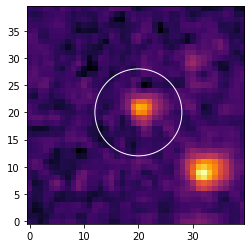

Mean: 50.16648864746094
Median: 48.143821716308594
Std dev: 12.104146957397461
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 32.056941825386716 ... 13.217361426962926   -2.802861914711822
  2 20.566238674797287 ...  6.877121704948935  -2.0935167753817554
  3 30.120532277686543 ... 1.0299621659995855 -0.03205317972557708
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


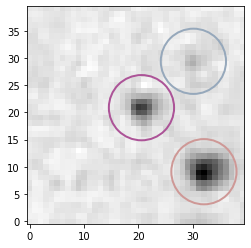

Time taken to fit PSF model: 0.037259199998516124s


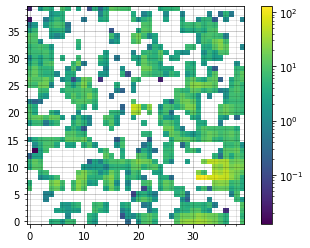

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 32.056942 9.0831544    15.543226 0.034676666
  2        2             1 20.566239 20.859915    16.296532 0.034886327
  3        3             1 30.120532 29.393767    18.323376 0.069462328
id_master    x_0       y_0      x_true  ...    dec      mag_e1     err_e1  
--------- --------- --------- --------- ... --------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ... 12.786927        --          --
        1 32.059451 9.3539851 970.18445 ... 12.781852 15.543226 0.034676666
        2 20.586063  21.13464 958.71106 ... 12.782865 16.296532 0.034886327
        3 30.238831 29.537477 968.36383 ... 12.780842 18.323376 0.069462328
        4 2.0765183 36.913621 940.20152 ... 12.784705        --          --
        5 36.531725  9.004675 974.65673 ... 12.781186        --          --






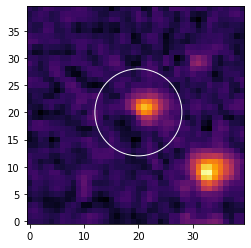

Mean: 52.373931884765625
Median: 50.68198776245117
Std dev: 11.348126411437988
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.8352648797611826 ...  1.113867213218019 -0.11708355159169098
  2  32.82837989669648 ... 14.104367926233074  -2.8733840710884584
  3 21.386226609209693 ...  8.141953993877834   -2.276821610171876
  4 30.989095624585374 ...  1.252363264457057   -0.244325799954063
  5 36.958227875324695 ... 1.0766286066064408 -0.08016478768270795
Number of PSF stars: 5


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


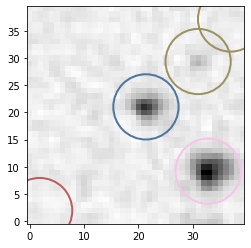

Time taken to fit PSF model: 0.04796300000089104s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


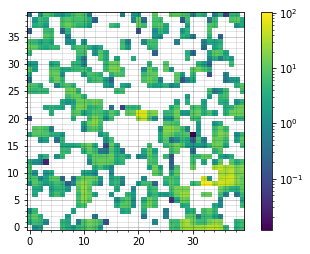

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 1.8352649   1.93532          nan         nan
  2        2             1  32.82838 9.1745318    15.562822 0.033282893
  3        3             1 21.386227  21.00899    16.180785 0.035657593
  4        4             1 30.989096 29.351748    18.553949 0.064048406
  5        4             1 36.958228 37.173409    21.865054   1.2593339
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --       nan         nan
        1 32.059451 9.3539851 970.18445 ... 0.034676666 15.562822 0.033282893
        2 20.586063  21.13464 958.71106 ... 0.034886327 16.180785 0.035657593
        3 30.238831 29.537477 968.36383 ... 0.069462328 18.553949 0.064048406
        4 2.0765183 36.91362

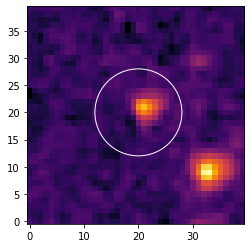

Mean: 55.17861557006836
Median: 53.11323547363281
Std dev: 13.009499549865723
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  32.77201113250941 ... 13.305339965340801  -2.8100649392676154
  2  21.26025339233436 ...  7.532100853786757   -2.192290316316237
  3 31.047085396672557 ... 1.0440797685886083 -0.04683420101055197
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


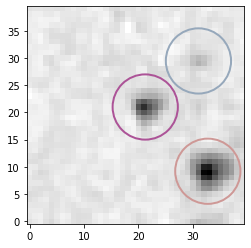

Time taken to fit PSF model: 0.04909669999869948s


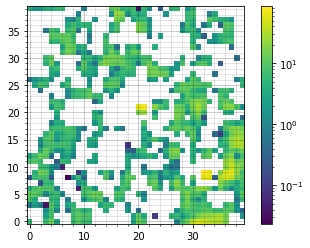

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 32.772011 9.1705254    15.497694 0.032752499
  2        2             1 21.260253 20.985347    16.155527 0.036400549
  3        3             1 31.047085  29.45898     18.37124 0.060277038
  4        1             2 21.345031 20.172399    20.380993   1.0183871
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...         nan        --          --
        1 32.059451 9.3539851 970.18445 ... 0.033282893 15.497694 0.032752499
        2 20.586063  21.13464 958.71106 ... 0.035657593 16.155527 0.036400549
        2 20.586063  21.13464 958.71106 ... 0.035657593 20.380993   1.0183871
        3 30.238831 29.537477 968.36383 ... 0.064048406  18.37124 0.060277038
        4 2.0765183 36

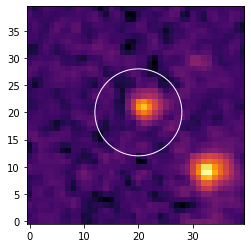

Mean: 50.725921630859375
Median: 49.411094665527344
Std dev: 12.372455596923828
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  32.69328327709138 ... 14.325333083537828  -2.890261821740061
  2 21.096833935351665 ...  7.961404451711487 -2.2524742182844153
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


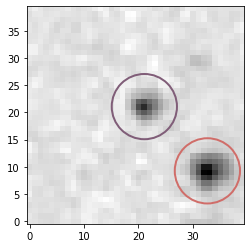

Time taken to fit PSF model: 0.03200230000038573s


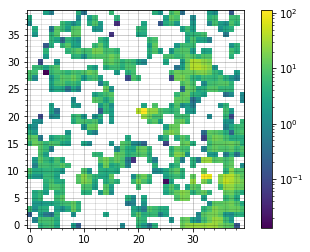

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 32.693283 9.2404928    15.474515 0.032608048
  2        2             1 21.096834 21.058798    16.240615 0.039334081
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --        --          --
        1 32.059451 9.3539851 970.18445 ... 0.032752499 15.474515 0.032608048
        2 20.586063  21.13464 958.71106 ... 0.036400549 16.240615 0.039334081
        2 20.586063  21.13464 958.71106 ...   1.0183871 16.240615 0.039334081
        3 30.238831 29.537477 968.36383 ... 0.060277038        --          --
        4 2.0765183 36.913621 940.20152 ...          --        --          --
        5 36.531725  9.004675 974.65673 ...          --        --          --






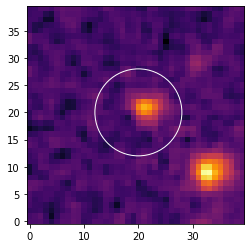

Mean: 51.814510345458984
Median: 50.36166763305664
Std dev: 12.46781063079834
sources_PSF:   id     xcentroid     ...        flux                 mag         
--- ----------------- ... ------------------ ---------------------
  1 32.79415393754553 ...  13.81916017951525    -2.851204127044655
  2 21.38691544615328 ...  7.063614647109938   -2.1225674961014787
  3 36.96412454201243 ... 1.0424312474053925 -0.045118552742568964
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


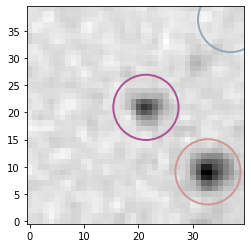

Time taken to fit PSF model: 0.03792200000134471s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


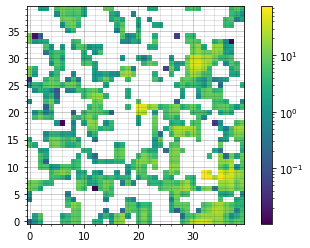

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 32.794154 9.0590403    15.484386 0.032579533
  2        2             1 21.386915 20.920395    16.222996 0.034844164
  3        3             1 36.964125 37.079141     21.32317  0.93731598
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --        --          --
        1 32.059451 9.3539851 970.18445 ... 0.032608048 15.484386 0.032579533
        2 20.586063  21.13464 958.71106 ... 0.039334081 16.222996 0.034844164
        2 20.586063  21.13464 958.71106 ... 0.039334081 16.222996 0.034844164
        3 30.238831 29.537477 968.36383 ...          --        --          --
        4 2.0765183 36.913621 940.20152 ...          --        --          --
        5 36.531

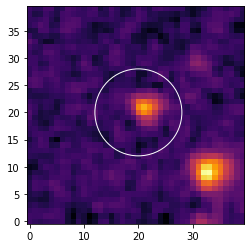

Mean: 54.09526824951172
Median: 52.19424057006836
Std dev: 13.288369178771973
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 32.80493680953714 ...  12.52444441973514 -2.7443961745129037
  2 21.23432411206328 ... 6.4337214058052865  -2.021155627682742
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


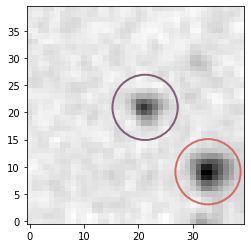

Time taken to fit PSF model: 0.03217740000036429s


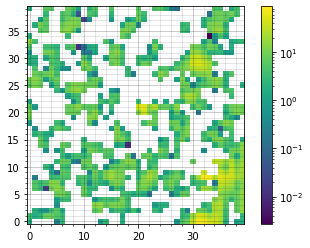

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 32.804937 9.0793662    15.502407  0.03241819
  2        2             1 21.234324 20.922077    16.303836 0.036318454
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --        --          --
        1 32.059451 9.3539851 970.18445 ... 0.032579533 15.502407  0.03241819
        2 20.586063  21.13464 958.71106 ... 0.034844164 16.303836 0.036318454
        2 20.586063  21.13464 958.71106 ... 0.034844164 16.303836 0.036318454
        3 30.238831 29.537477 968.36383 ...          --        --          --
        4 2.0765183 36.913621 940.20152 ...          --        --          --
        5 36.531725  9.004675 974.65673 ...          --        --          --






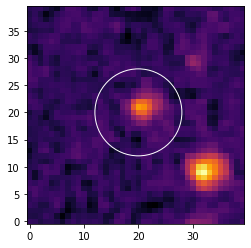

Mean: 54.860504150390625
Median: 53.37672424316406
Std dev: 11.33218002319336
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 32.032561800303576 ...  14.41345991833103    -2.896920611832665
  2 20.686866468465833 ...  6.622195146056118   -2.0525049365122565
  3 30.443246758769607 ... 1.1186548894757673   -0.1217403130294554
  4 36.806839705046876 ... 1.0226591155219489 -0.024327234527352446
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


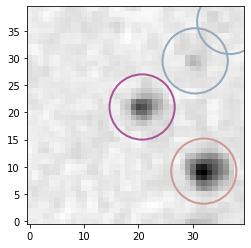

Time taken to fit PSF model: 0.04712119999931019s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


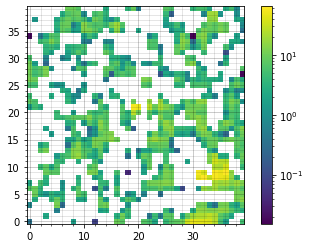

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 32.032562 9.1950738     15.56261 0.033128701
  2        2             1 20.686866 20.987361    16.409332 0.036076305
  3        3             1 30.443247 29.477814    18.427274 0.068200328
  4        3             1  36.80684 36.725003    20.232604  0.32941025
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --        --          --
        1 32.059451 9.3539851 970.18445 ...  0.03241819  15.56261 0.033128701
        2 20.586063  21.13464 958.71106 ... 0.036318454 16.409332 0.036076305
        2 20.586063  21.13464 958.71106 ... 0.036318454 16.409332 0.036076305
        3 30.238831 29.537477 968.36383 ...          -- 18.427274 0.068200328
        4 2.0765183 36

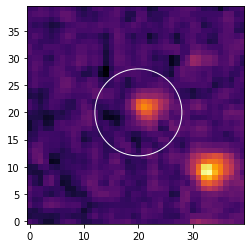

Mean: 47.52449417114258
Median: 45.766815185546875
Std dev: 12.090496063232422
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1 32.88572034799637 ... 14.743397752804212 -2.9214939556265955
  2 21.45485338834492 ...  5.409067751508682  -1.832806053125444
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


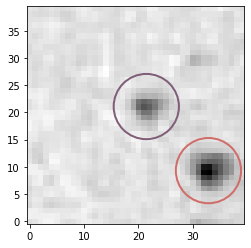

Time taken to fit PSF model: 0.03567029999976512s


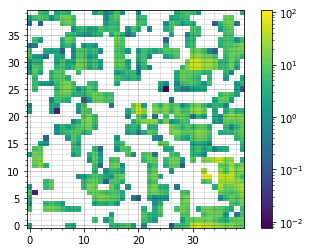

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  32.88572 9.2855552    15.522921 0.033193474
  2        2             1 21.454853 21.069174    16.491587 0.036363705
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --        --          --
        1 32.059451 9.3539851 970.18445 ... 0.033128701 15.522921 0.033193474
        2 20.586063  21.13464 958.71106 ... 0.036076305 16.491587 0.036363705
        2 20.586063  21.13464 958.71106 ... 0.036076305 16.491587 0.036363705
        3 30.238831 29.537477 968.36383 ... 0.068200328        --          --
        4 2.0765183 36.913621 940.20152 ...          --        --          --
        5 36.531725  9.004675 974.65673 ...          --        --          --






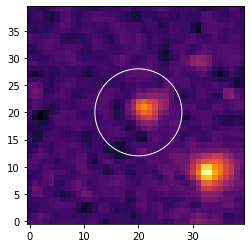

Mean: 59.797027587890625
Median: 57.96266555786133
Std dev: 11.894145011901855
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 2.5582637296160855 ... 1.1114767621876893  -0.11475096817421868
  2 32.829053331949666 ... 14.576139370304341    -2.909106280429461
  3 21.342064969686678 ...  6.023025747091437    -1.949536799216438
  4 31.295609093700136 ... 1.2477791239126046  -0.24034428837490185
  5  36.90074479611431 ... 1.0109008414914153 -0.011771395146888219
Number of PSF stars: 5


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


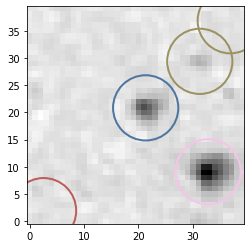

Time taken to fit PSF model: 0.050094099999114405s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


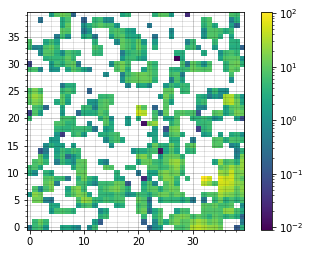

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.5582637 1.9158988    21.810473   1.3618904
  2        2             1 32.829053 9.0903977    15.492939  0.03331669
  3        3             1 21.342065 20.827054    16.459508 0.035261779
  4        4             1 31.295609 29.385186    18.413845 0.062480683
  5        4             1 36.900745 36.857861          nan         nan
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          -- 21.810473   1.3618904
        1 32.059451 9.3539851 970.18445 ... 0.033193474 15.492939  0.03331669
        2 20.586063  21.13464 958.71106 ... 0.036363705 16.459508 0.035261779
        2 20.586063  21.13464 958.71106 ... 0.036363705 16.459508 0.035261779
        3 30.238831 29.53747

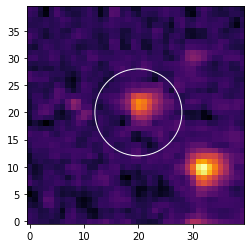

Mean: 54.41813278198242
Median: 52.609832763671875
Std dev: 11.932707786560059
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  37.00231487537603 ... 1.0570227230143605 -0.06021080879287017
  2 32.000862814839415 ... 14.458117192715962   -2.900279351681614
  3 20.435103987418884 ...  5.986722107852303  -1.9429727487434942
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


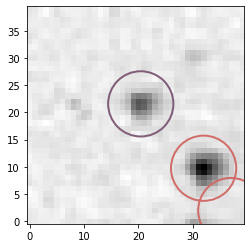

Time taken to fit PSF model: 0.03945009999915783s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


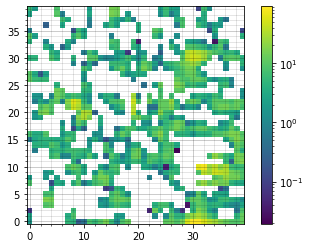

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 37.002315 1.9358461    20.731717   1.5462759
  2        1             1 32.000863 9.7200784    15.540912 0.032000926
  3        2             1 20.435104 21.563103     16.40856 0.033113516
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...   1.3618904        --          --
        1 32.059451 9.3539851 970.18445 ...  0.03331669 15.540912 0.032000926
        2 20.586063  21.13464 958.71106 ... 0.035261779  16.40856 0.033113516
        2 20.586063  21.13464 958.71106 ... 0.035261779  16.40856 0.033113516
        3 30.238831 29.537477 968.36383 ... 0.062480683        --          --
        4 2.0765183 36.913621 940.20152 ...          --        --          --
        5 36.531

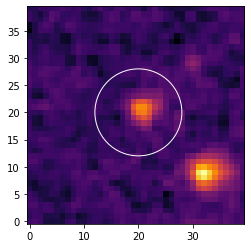

Mean: 55.417938232421875
Median: 53.84947967529297
Std dev: 11.895033836364746
sources_PSF:   id     xcentroid     ...        flux                 mag         
--- ----------------- ... ------------------ ---------------------
  1 32.12280006353452 ... 14.809712885633555    -2.926366597451956
  2 20.74695064576119 ...  6.522016256277856   -2.0359546924010683
  3 29.97537624947882 ... 1.0213563961991847 -0.022943282481234905
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


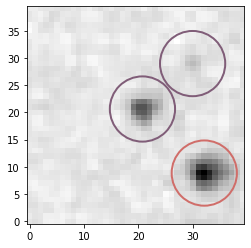

Time taken to fit PSF model: 0.04960730000129843s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


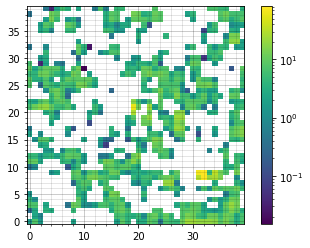

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1   32.1228 8.8313696    15.476083 0.034129866
  2        2             1 20.746951 20.617165    16.400167 0.031999409
  3        2             1 29.975376 28.972241    18.635701  0.10484214
  4        1             2 36.422053 8.4086442    18.159255  0.16515632
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --        --          --
        1 32.059451 9.3539851 970.18445 ... 0.032000926 15.476083 0.034129866
        2 20.586063  21.13464 958.71106 ... 0.033113516 16.400167 0.031999409
        2 20.586063  21.13464 958.71106 ... 0.033113516 16.400167 0.031999409
        3 30.238831 29.537477 968.36383 ...          -- 18.635701  0.10484214
        4 2.0765183 36

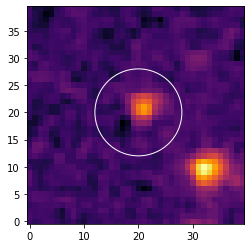

Mean: 55.567447662353516
Median: 53.95244216918945
Std dev: 12.570528984069824
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  32.31311376992147 ... 12.269310804196879  -2.722050420195532
  2 20.980267893053963 ...  6.270999300757037 -1.9933418808741994
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


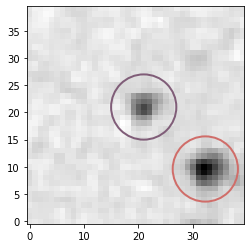

Time taken to fit PSF model: 0.04192280000097526s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


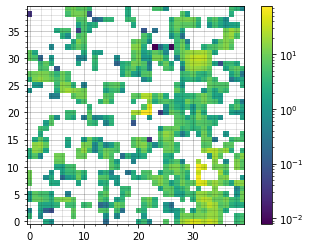

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 32.313114 9.5821566    15.552282 0.032067305
  2        2             1 20.980268 20.982404    16.434628 0.038811396
  3        1             2 37.610151  7.997992    18.148462  0.13685766
id_master    x_0       y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 2.0975844 2.1042083 940.22259 ...          --        --          --
        1 32.059451 9.3539851 970.18445 ... 0.034129866 15.552282 0.032067305
        2 20.586063  21.13464 958.71106 ... 0.031999409 16.434628 0.038811396
        2 20.586063  21.13464 958.71106 ... 0.031999409 16.434628 0.038811396
        3 30.238831 29.537477 968.36383 ...  0.10484214        --          --
        4 2.0765183 36.913621 940.20152 ...          --        --          --
        5 36.531

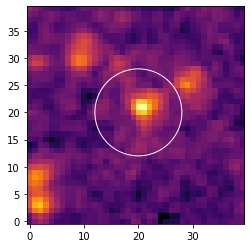

Mean: 61.387325286865234
Median: 55.227691650390625
Std dev: 24.263280868530273
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.8966327531098872 ...  2.386404466628075  -0.9443601330570219
  2 20.854164631328835 ... 3.5485092642419076  -1.3751148584929938
  3 29.110325533236228 ... 1.1750811078264614 -0.17516961006360837
  4  9.385480233937166 ... 1.2135247475925557 -0.21012159347725184
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


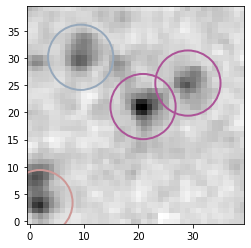

Time taken to fit PSF model: 0.04505980000067211s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


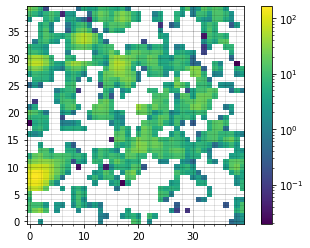

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 1.8966328 3.3880264    16.807179 0.085794539
  2        2             1 20.854165 21.066297    16.261151 0.033494743
  3        2             1 29.110326 25.386066     17.23376 0.047485283
  4        3             1 9.3854802 30.134726     17.07237 0.053135476
id_master    x_0       y_0      x_true  ...    dec      mag_e1     err_e1  
--------- --------- --------- --------- ... --------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ... 12.774958 16.807179 0.085794539
        1 20.925764 21.502948 1052.4174 ...   12.7709 16.261151 0.033494743
        2 28.961276 25.661973 1060.4529 ... 12.769398  17.23376 0.047485283
        3 9.3078731 30.496108 1040.7995 ... 12.772114  17.07237 0.053135476
        4 1.2860701 8.5495846 1032.7777 ... 12.774751        --          --






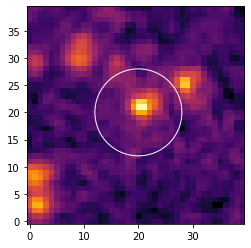

Mean: 62.422271728515625
Median: 56.50028991699219
Std dev: 23.053064346313477
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.7575589740458537 ...  2.259188003274215  -0.8848809329750841
  2 20.642964370534816 ...  3.505948492289257  -1.3620138283969563
  3 28.640111663339958 ... 2.2539972617023016  -0.8823834602553629
  4  9.194227068271749 ... 1.1720908304917566 -0.17240317095614133
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


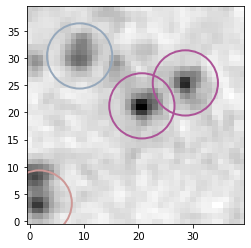

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

Time taken to fit PSF model: 0.13506080000115617s


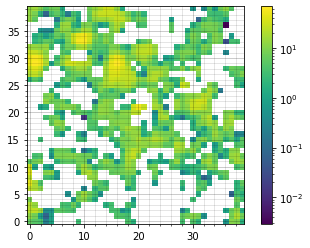

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  1.757559 3.3236426    16.841166 0.096899692
  2        2             1 20.642964 21.196365    16.292434 0.034331503
  3        2             1 28.640112  25.41451    16.737223 0.038784717
  4        3             1 9.1942271 30.377228    17.160971 0.053573324
  5        1             2 1.2985436 8.4016986    16.876844 0.045163324
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ... 0.085794539 16.841166 0.096899692
        1 20.925764 21.502948 1052.4174 ... 0.033494743 16.292434 0.034331503
        2 28.961276 25.661973 1060.4529 ... 0.047485283 16.737223 0.038784717
        3 9.3078731 30.496108 1040.7995 ... 0.053135476 17.160971 0.053573324
        4 1.2860701 8.549584

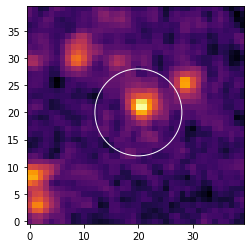

Mean: 65.46654510498047
Median: 59.725555419921875
Std dev: 22.579030990600586
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 1.8431367468407158 ...  1.949394676735778 -0.7247494394766986
  2 20.615904831042652 ...  4.197892550369022 -1.5575782953711772
  3 28.690778877891738 ...  2.244487631189038 -0.8777930411395127
  4  8.849021767617002 ... 1.5562220364925712 -0.4801789018528129
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


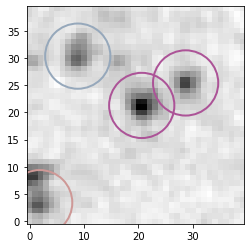

Time taken to fit PSF model: 0.06149059999916062s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

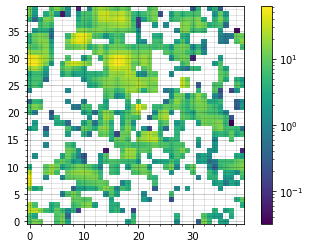

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 1.8431367 3.3854188    17.014865  0.12405893
  2        2             1 20.615905 21.274383    16.140277 0.032187374
  3        2             1 28.690779 25.412641    16.866457 0.038107896
  4        3             1 8.8490218 30.342742    17.102594 0.046942963
  5        1             2  1.049617 8.4407171    16.768032 0.042629163
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ... 0.096899692 17.014865  0.12405893
        1 20.925764 21.502948 1052.4174 ... 0.034331503 16.140277 0.032187374
        2 28.961276 25.661973 1060.4529 ... 0.038784717 16.866457 0.038107896
        3 9.3078731 30.496108 1040.7995 ... 0.053573324 17.102594 0.046942963
        4 1.2860701 8.549584

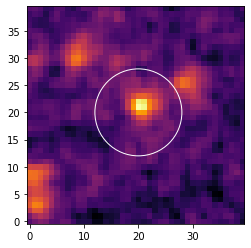

Mean: 62.815181732177734
Median: 55.99862289428711
Std dev: 25.82511329650879
sources_PSF:   id     xcentroid     ...        flux                mag         
--- ----------------- ... ------------------ --------------------
  1   20.542034330187 ... 3.6340959110603914  -1.4009909625584203
  2 28.83702696363152 ... 1.1424527946784377 -0.14459566094835508
  3 8.777451950848741 ... 1.3292680429676227  -0.3090314099266921
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


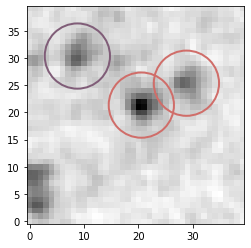

Time taken to fit PSF model: 0.053232000000207336s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


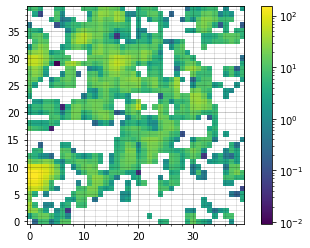

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 20.542034 21.334362    16.136938 0.033509926
  2        1             1 28.837027 25.364529    17.154764 0.048719767
  3        2             1  8.777452 30.357729    17.051762 0.048531455
  4        1             2 1.5813368 3.5281768    16.996831  0.11639331
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ...  0.12405893 16.996831  0.11639331
        1 20.925764 21.502948 1052.4174 ... 0.032187374 16.136938 0.033509926
        2 28.961276 25.661973 1060.4529 ... 0.038107896 17.154764 0.048719767
        3 9.3078731 30.496108 1040.7995 ... 0.046942963 17.051762 0.048531455
        4 1.2860701 8.5495846 1032.7777 ... 0.042629163        --          --






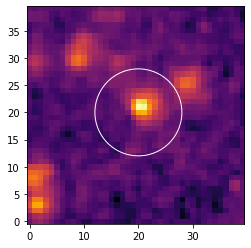

Mean: 64.56059265136719
Median: 57.907867431640625
Std dev: 24.908544540405273
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.8033480144793983 ... 2.1712982859689984   -0.841798723826967
  2 20.656869519521912 ... 3.9515605342439137  -1.4919215982875835
  3 28.891934477695656 ...   1.21939215869433 -0.21535849490662462
  4  9.048972638935037 ... 1.3784366633975609   -0.348467039690129
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


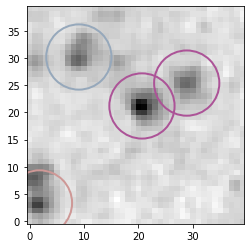

Time taken to fit PSF model: 0.05733180000061111s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

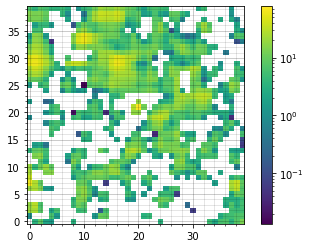

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  1.803348 3.3394369    16.816404 0.090524831
  2        2             1  20.65687 21.177712     16.07626 0.033149612
  3        2             1 28.891934  25.38708    17.156663 0.048086094
  4        3             1 9.0489726 30.182348    17.054134 0.050379497
  5        1             2 1.2970301 8.2757095    16.960274 0.052048817
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ...  0.11639331 16.816404 0.090524831
        1 20.925764 21.502948 1052.4174 ... 0.033509926  16.07626 0.033149612
        2 28.961276 25.661973 1060.4529 ... 0.048719767 17.156663 0.048086094
        3 9.3078731 30.496108 1040.7995 ... 0.048531455 17.054134 0.050379497
        4 1.2860701 8.549584

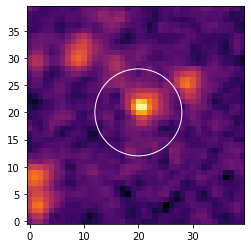

Mean: 67.05438232421875
Median: 60.37908172607422
Std dev: 26.179210662841797
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.598441185302647 ... 3.7007074600637306 -1.4207118889729187
  2 28.976557475701146 ...   1.39989454141327 -0.3652383002538503
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


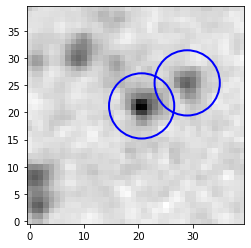

Time taken to fit PSF model: 0.05528020000019751s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


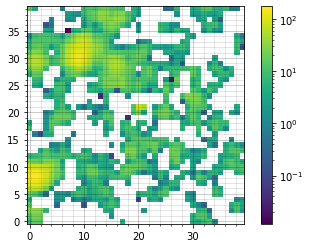

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 20.598441 21.185538    16.102535 0.033285244
  2        1             1 28.976557 25.421048    17.120504 0.046669431
  3        1             2  1.643039 3.4646416    17.034486  0.11120272
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ... 0.090524831 17.034486  0.11120272
        1 20.925764 21.502948 1052.4174 ... 0.033149612 16.102535 0.033285244
        2 28.961276 25.661973 1060.4529 ... 0.048086094 17.120504 0.046669431
        3 9.3078731 30.496108 1040.7995 ... 0.050379497        --          --
        4 1.2860701 8.5495846 1032.7777 ... 0.052048817        --          --






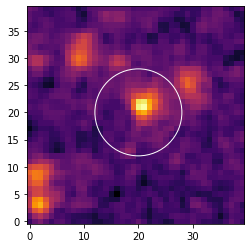

Mean: 67.5267105102539
Median: 60.95513153076172
Std dev: 25.46190643310547
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.9431149673362513 ...  2.355806413730646  -0.9303489995588953
  2 20.887862000720464 ... 3.9837086829784756   -1.500718930553385
  3  29.16034255712224 ... 1.0858248353051327 -0.08939942686110267
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


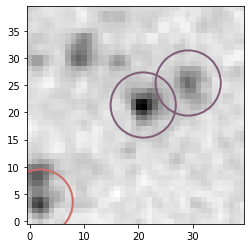

Time taken to fit PSF model: 0.04425919999994221s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


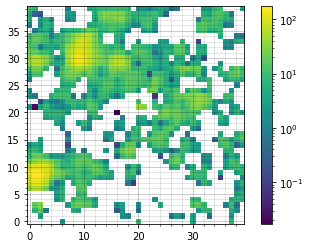

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  1.943115  3.490649    16.817142 0.084744647
  2        2             1 20.887862 21.350516    16.149997 0.032770109
  3        2             1 29.160343 25.397874    17.245243 0.049512632
id_master    x_0       y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ...  0.11120272 16.817142 0.084744647
        1 20.925764 21.502948 1052.4174 ... 0.033285244 16.149997 0.032770109
        2 28.961276 25.661973 1060.4529 ... 0.046669431 17.245243 0.049512632
        3 9.3078731 30.496108 1040.7995 ...          --        --          --
        4 1.2860701 8.5495846 1032.7777 ...          --        --          --






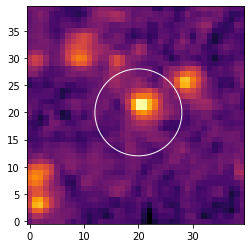

Mean: 60.7364387512207
Median: 54.30284118652344
Std dev: 24.908170700073242
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  1.863767952277327 ... 2.1614789822772766  -0.8368775422772535
  2 20.749061316899457 ... 3.6739404046362125  -1.4128302682290768
  3  28.81060012948741 ... 2.2568943072364553  -0.8837780527023997
  4   9.20552593864841 ... 1.1973857384894624 -0.19558520289685788
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


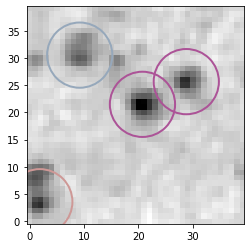

Time taken to fit PSF model: 0.04911010000068927s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


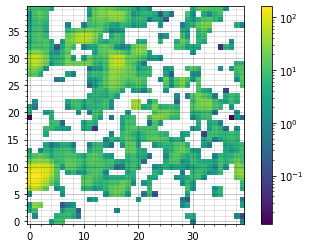

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  1.863768 3.5600505    16.868768  0.10093085
  2        2             1 20.749061 21.476605    16.205665 0.033277763
  3        2             1   28.8106 25.652221    16.776062 0.039624641
  4        3             1 9.2055259 30.528343    17.146376 0.053281661
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ... 0.084744647 16.868768  0.10093085
        1 20.925764 21.502948 1052.4174 ... 0.032770109 16.205665 0.033277763
        2 28.961276 25.661973 1060.4529 ... 0.049512632 16.776062 0.039624641
        3 9.3078731 30.496108 1040.7995 ...          -- 17.146376 0.053281661
        4 1.2860701 8.5495846 1032.7777 ...          --        --          --






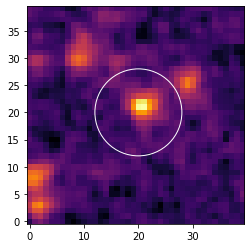

Mean: 70.90702056884766
Median: 65.38802337646484
Std dev: 22.25787925720215
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.9476118873080313 ... 1.9195513210103232  -0.7079993197004196
  2 20.719040339413326 ... 3.9937816005754234  -1.5034607796176822
  3  29.04572393241464 ... 1.5066878190323574 -0.44505819296914684
  4  9.270698052156538 ... 1.4255459899446061  -0.3849530819232056
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


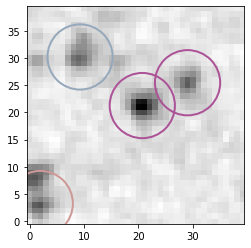

Time taken to fit PSF model: 0.0495524000016303s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


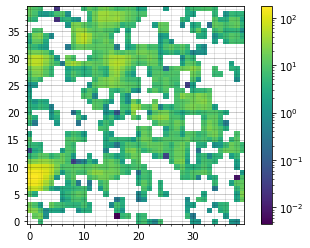

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 1.9476119 3.2309778    17.095957  0.12068322
  2        2             1  20.71904  21.24967    16.223799 0.032651956
  3        2             1 29.045724 25.449965    17.173383 0.043699099
  4        3             1 9.2706981 30.187436    17.061049 0.052049102
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ...  0.10093085 17.095957  0.12068322
        1 20.925764 21.502948 1052.4174 ... 0.033277763 16.223799 0.032651956
        2 28.961276 25.661973 1060.4529 ... 0.039624641 17.173383 0.043699099
        3 9.3078731 30.496108 1040.7995 ... 0.053281661 17.061049 0.052049102
        4 1.2860701 8.5495846 1032.7777 ...          --        --          --






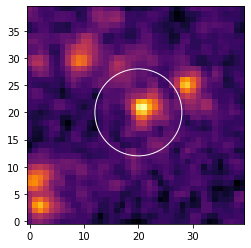

Mean: 65.11148834228516
Median: 59.23456573486328
Std dev: 22.24269676208496
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1   2.13411529566097 ... 2.4185759753005596  -0.9588993363357234
  2 20.927877500565852 ...  4.041611693215537  -1.5163864634512283
  3  28.94616094838846 ... 2.7632088309542846  -1.1035342704743059
  4  9.339458788776962 ... 1.5698113094969892 -0.48961863393860044
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


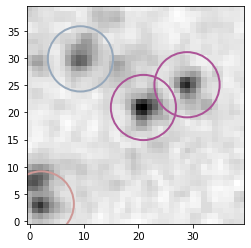

Time taken to fit PSF model: 0.06270899999981339s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

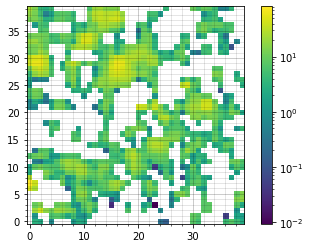

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.1341153 3.1528031    16.741026  0.10420167
  2        2             1 20.927878  20.89548    16.243658 0.034840084
  3        2             1 28.946161 25.082268    16.733509  0.04128335
  4        3             1 9.3394588 29.838595    16.937309 0.045568479
  5        1             2 1.3535108 7.9361754    16.844573 0.058392579
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ...  0.12068322 16.741026  0.10420167
        1 20.925764 21.502948 1052.4174 ... 0.032651956 16.243658 0.034840084
        2 28.961276 25.661973 1060.4529 ... 0.043699099 16.733509  0.04128335
        3 9.3078731 30.496108 1040.7995 ... 0.052049102 16.937309 0.045568479
        4 1.2860701 8.549584

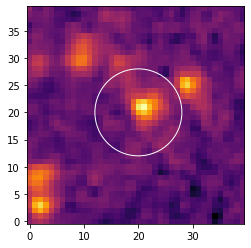

Mean: 66.61089324951172
Median: 59.918487548828125
Std dev: 24.670778274536133
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   2.05667226638328 ...   2.51545961463754 -1.0015433729470435
  2  1.952828373571022 ... 1.6804679728364975 -0.5635755997303077
  3 21.050431765058757 ...  3.191650019532296 -1.2600381567914363
  4 29.032990937791695 ...  2.285994471602457 -0.8976879394313487
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


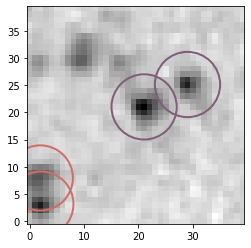

Time taken to fit PSF model: 0.04376570000022184s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


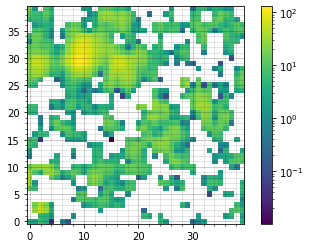

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.0566723 3.1222173    16.778705  0.04343153
  2        1             1 1.9528284 7.9314798    17.061434 0.050909335
  3        2             1 21.050432 21.006836    16.305521 0.034740261
  4        2             1 29.032991 25.120667    16.774276 0.040494033
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ...  0.10420167 16.778705  0.04343153
        1 20.925764 21.502948 1052.4174 ... 0.034840084 16.305521 0.034740261
        2 28.961276 25.661973 1060.4529 ...  0.04128335 16.774276 0.040494033
        3 9.3078731 30.496108 1040.7995 ... 0.045568479        --          --
        4 1.2860701 8.5495846 1032.7777 ... 0.058392579 17.061434 0.050909335






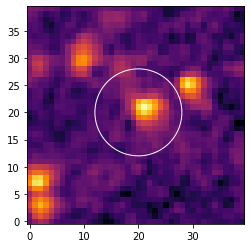

Mean: 66.87299346923828
Median: 60.582271575927734
Std dev: 24.66910743713379
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2.233052729109313 ... 1.7978222831630586 -0.6368668975027063
  2 1.8265929867364776 ... 2.4608018984817885 -0.9776916329372896
  3 21.328233268079472 ...  2.769871801670683  -1.106149172556954
  4 29.387164923403112 ... 2.4462142294472375 -0.9712362202550661
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


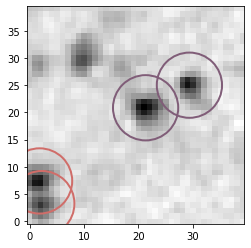

Time taken to fit PSF model: 0.046373299999686424s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


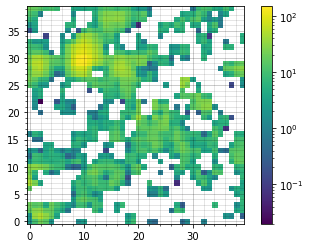

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 2.2330527 3.2188466    17.168505 0.056851345
  2        1             1  1.826593  7.384478    16.756172 0.042824634
  3        2             1 21.328233 20.843298    16.327849 0.035668047
  4        2             1 29.387165 24.997262    16.671202 0.040743584
id_master    x_0       y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 1.9750052 3.6551406 1033.4666 ...  0.04343153 17.168505 0.056851345
        1 20.925764 21.502948 1052.4174 ... 0.034740261 16.327849 0.035668047
        2 28.961276 25.661973 1060.4529 ... 0.040494033 16.671202 0.040743584
        3 9.3078731 30.496108 1040.7995 ...          --        --          --
        4 1.2860701 8.5495846 1032.7777 ... 0.050909335 16.756172 0.042824634




Star ID:  1
star_n

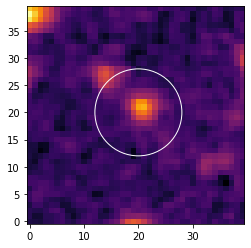

Mean: 53.324405670166016
Median: 50.17864990234375
Std dev: 14.438337326049805
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.665083676678364 ...  5.890526749339548   -1.92538533123889
  2  13.95603222705414 ...  2.492135458379767 -0.9914291110473146
  3 0.9125703564227702 ... 10.695305387290407  -2.572982974167315
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


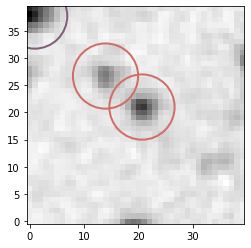

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.12304089999997814s


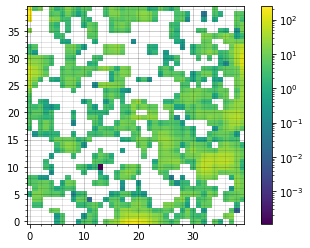

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  20.665084 20.976952     16.24395 0.032298258
  2        1             1  13.956032 26.680989    17.195135 0.041363093
  3        2             1 0.91257036 37.722258    15.816752 0.056865524
id_master    x_0        y_0      x_true  ...    dec      mag_e1     err_e1  
--------- ---------- --------- --------- ... --------- --------- -----------
        0  33.096021  10.97261 1003.3595 ... 12.778506        --          --
        1  20.722962 21.194848 990.98647 ... 12.779757  16.24395 0.032298258
        2  13.911792 26.854897  984.1753 ... 12.780443 17.195135 0.041363093
        3 0.87539713 37.905959  971.1389 ... 12.781744 15.816752 0.056865524






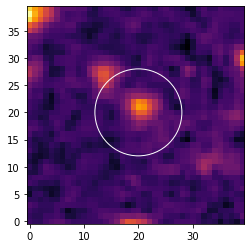

Mean: 56.535888671875
Median: 53.85014343261719
Std dev: 14.681736946105957
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.433719669499908 ...  4.977913730230377  -1.742618414485395
  2 13.700733598303616 ... 2.6982040300157566 -1.0776869665270052
  3 0.8256119414656018 ...  9.701509555756454 -2.4670982894613442
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


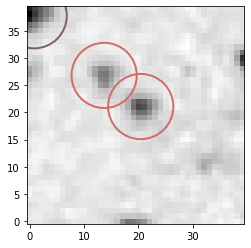

Time taken to fit PSF model: 0.03933759999927133s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


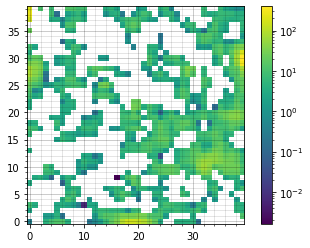

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   20.43372 21.069462    16.391237 0.033627083
  2        1             1  13.700734 26.798012    17.077722 0.041042302
  3        2             1 0.82561194 37.775805    15.894601 0.065597449
id_master    x_0        y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.032298258 16.391237 0.033627083
        2  13.911792 26.854897  984.1753 ... 0.041363093 17.077722 0.041042302
        3 0.87539713 37.905959  971.1389 ... 0.056865524 15.894601 0.065597449






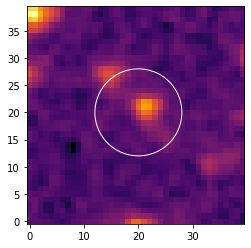

Mean: 59.42101287841797
Median: 56.176116943359375
Std dev: 16.642120361328125
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.450318580864263 ...  5.130547863307668 -1.7754093588356157
  2 14.677630581305698 ...  2.070779709539063 -0.7903347522792876
  3 1.0528675935104819 ... 12.093952742071966 -2.7064206680963654
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


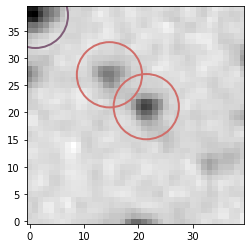

Time taken to fit PSF model: 0.044372099999236525s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


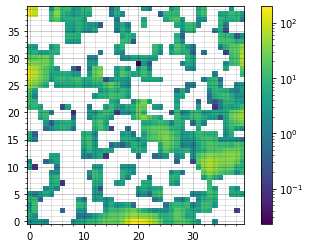

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.450319 21.051388    16.230694 0.033690757
  2        1             1 14.677631 26.914638    17.080037 0.045157028
  3        2             1 1.0528676 37.840407    15.507349 0.044207999
id_master    x_0        y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.033627083 16.230694 0.033690757
        2  13.911792 26.854897  984.1753 ... 0.041042302 17.080037 0.045157028
        3 0.87539713 37.905959  971.1389 ... 0.065597449 15.507349 0.044207999






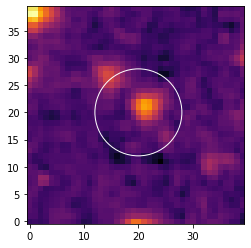

Mean: 54.919857025146484
Median: 51.46244430541992
Std dev: 16.306005477905273
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.364566273412937 ...  5.638771899005449 -1.8779613168898917
  2 14.505618894620103 ... 1.9781985230852668 -0.7406746832111905
  3 1.0144752704874849 ... 12.699163205391955 -2.7594377615918835
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


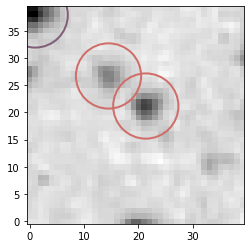

Time taken to fit PSF model: 0.051484999999956926s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

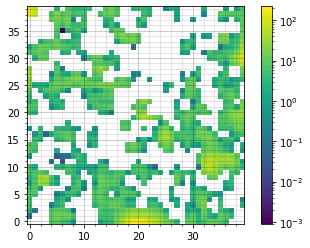

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  21.364566 21.163921    16.198025 0.032666401
  2        1             1  14.505619 26.695777    17.164291 0.044332106
  3        2             1  1.0144753 37.918177    15.465678 0.044467323
  4        1             2 0.64771428 27.271221    17.867406 0.064861494
id_master    x_0        y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.033690757 16.198025 0.032666401
        2  13.911792 26.854897  984.1753 ... 0.045157028 17.164291 0.044332106
        3 0.87539713 37.905959  971.1389 ... 0.044207999 15.465678 0.044467323






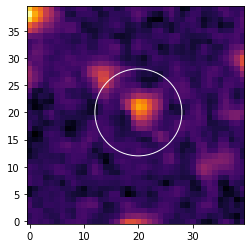

Mean: 55.94745635986328
Median: 52.527244567871094
Std dev: 16.26184844970703
sources_PSF:   id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1  20.42347783158141 ... 5.598710143965956  -1.870219959532836
  2 13.515622902298622 ... 2.118937129593117 -0.8152951776714543
  3 0.7887619018038631 ... 9.118520344459016 -2.3998109285043285
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


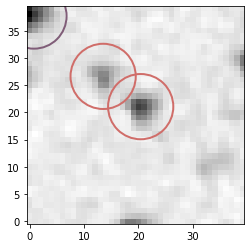

Time taken to fit PSF model: 0.055829699998867s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Ja

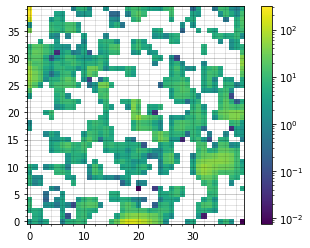

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 20.423478 21.052618    16.145966 0.033428779
  2        1             1 13.515623 26.618955    17.116771 0.045987641
  3        2             1 0.7887619 37.717073    15.851804 0.067998247
  4        1             2 38.615833 29.603479      17.5081 0.065925163
id_master    x_0        y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.032666401 16.145966 0.033428779
        2  13.911792 26.854897  984.1753 ... 0.044332106 17.116771 0.045987641
        3 0.87539713 37.905959  971.1389 ... 0.044467323 15.851804 0.067998247






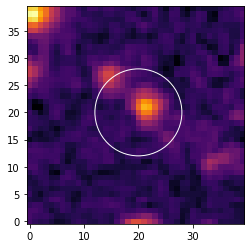

Mean: 58.21970748901367
Median: 54.084617614746094
Std dev: 17.45290756225586
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.467201855340825 ...  5.184901974937958   -1.78685137522347
  2 14.699918249779461 ... 1.9577658781052483 -0.7294018873011253
  3 1.0955307193332036 ...  11.09880789486695 -2.6131908360467953
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


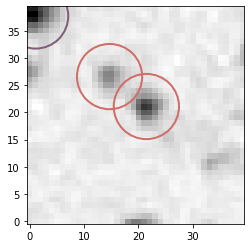

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.12586469999951078s


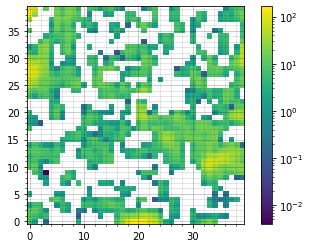

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.467202 21.075608    16.103851 0.032413203
  2        1             1 14.699918 26.581431    17.189656 0.043959457
  3        2             1 1.0955307 37.734967    15.556467 0.042427034
id_master    x_0        y_0      x_true  ...    err_e5     mag_e6     err_e6  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.033428779 16.103851 0.032413203
        2  13.911792 26.854897  984.1753 ... 0.045987641 17.189656 0.043959457
        3 0.87539713 37.905959  971.1389 ... 0.067998247 15.556467 0.042427034






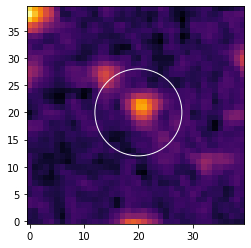

Mean: 58.02057647705078
Median: 54.659141540527344
Std dev: 16.016517639160156
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  20.66186965782033 ...  5.818767127061086 -1.9120774415932114
  2 13.979370392585036 ... 2.2725548645784897 -0.8912859421619262
  3 0.8975769566309115 ...   9.67710596264418  -2.464363741314787
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


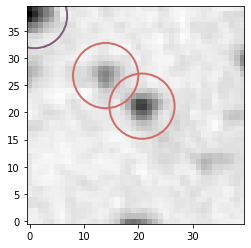

Time taken to fit PSF model: 0.041173600000547594s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


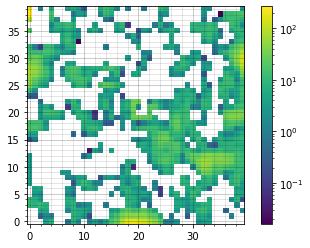

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   20.66187 21.136591    16.170598 0.032823294
  2        1             1   13.97937 26.766642    17.207374 0.046389874
  3        2             1 0.89757696   37.8005    15.792864 0.059156548
id_master    x_0        y_0      x_true  ...    err_e6     mag_e7     err_e7  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.032413203 16.170598 0.032823294
        2  13.911792 26.854897  984.1753 ... 0.043959457 17.207374 0.046389874
        3 0.87539713 37.905959  971.1389 ... 0.042427034 15.792864 0.059156548






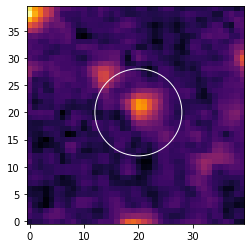

Mean: 52.89707565307617
Median: 49.17203903198242
Std dev: 16.069019317626953
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 20.508605870274472 ...  5.316207421696292 -1.8140047935156862
  2 13.722542373926236 ... 2.2477240025731042 -0.8793574581697572
  3 0.7753391336549348 ...  9.624518747139234  -2.458447556961171
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


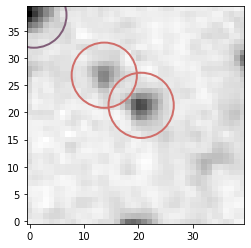

Time taken to fit PSF model: 0.0403972000003705s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


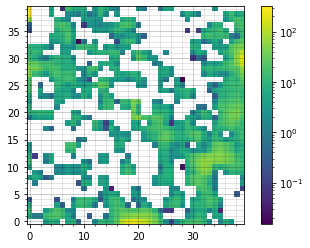

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  20.508606   21.2856     16.23224 0.032636588
  2        1             1  13.722542  26.83177    17.112083  0.04327148
  3        2             1 0.77533913 37.889085    15.755468 0.067724041
id_master    x_0        y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.032823294  16.23224 0.032636588
        2  13.911792 26.854897  984.1753 ... 0.046389874 17.112083  0.04327148
        3 0.87539713 37.905959  971.1389 ... 0.059156548 15.755468 0.067724041






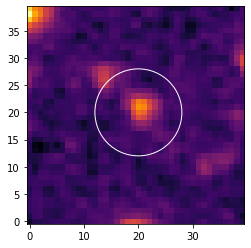

Mean: 63.535152435302734
Median: 60.260597229003906
Std dev: 15.34737777709961
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   20.4380698511166 ...  5.179919302942639   -1.78580748500029
  2 13.696008546772129 ... 2.1137815897891743  -0.812650277615746
  3 0.8374986176956953 ...  9.776843336443925 -2.4754966403290424
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


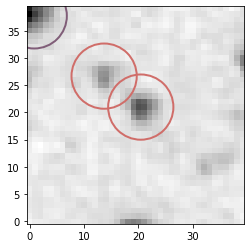

Time taken to fit PSF model: 0.04564179999943008s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


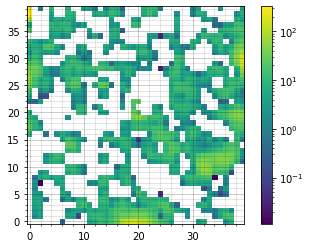

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   20.43807 20.970067    16.239968 0.033230889
  2        1             1  13.696009 26.664719    17.289568 0.046639333
  3        2             1 0.83749862 37.750522    15.830378 0.068405046
id_master    x_0        y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.032636588 16.239968 0.033230889
        2  13.911792 26.854897  984.1753 ...  0.04327148 17.289568 0.046639333
        3 0.87539713 37.905959  971.1389 ... 0.067724041 15.830378 0.068405046






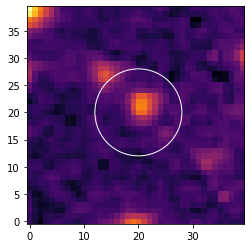

Mean: 57.89347839355469
Median: 54.85451889038086
Std dev: 15.277151107788086
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  33.01939047361226 ... 1.1145191822947624 -0.11771886910451217
  2 20.681245504040714 ...  5.047080228563449  -1.7576005208719916
  3 13.828926598852295 ... 2.5543858202426777  -1.0182162367698153
  4   0.84663905607303 ... 10.041088954272873   -2.504452036301986
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


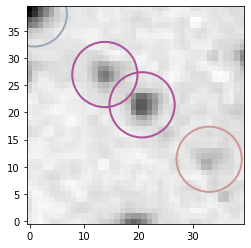

Time taken to fit PSF model: 0.04342519999954675s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


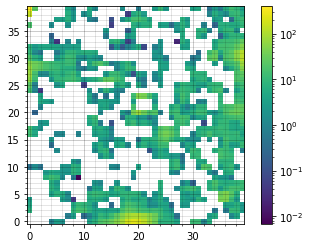

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1   33.01939 11.372684    17.966379 0.054444943
  2        2             1  20.681246  21.38502    16.404072 0.033648641
  3        2             1  13.828927 26.966204    17.096467 0.043626683
  4        3             1 0.84663906 38.109489    15.787578 0.068544409
id_master    x_0        y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          -- 17.966379 0.054444943
        1  20.722962 21.194848 990.98647 ... 0.033230889 16.404072 0.033648641
        2  13.911792 26.854897  984.1753 ... 0.046639333 17.096467 0.043626683
        3 0.87539713 37.905959  971.1389 ... 0.068405046 15.787578 0.068544409






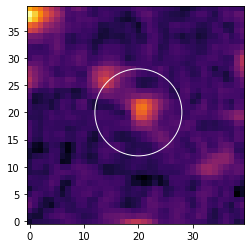

Mean: 59.31543731689453
Median: 55.51708221435547
Std dev: 17.72774314880371
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  20.76902593126813 ...  3.664012051736601 -1.4098922337191275
  2 13.972835675831334 ... 1.8475152155345052 -0.6664700594742814
  3 0.9167058418224585 ...  9.492544737515816 -2.4434566315194393
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


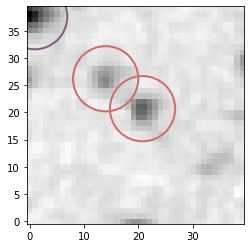

Time taken to fit PSF model: 0.04171390000010433s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


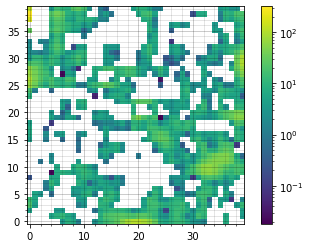

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  20.769026 20.675281    16.553979 0.034007806
  2        1             1  13.972836 26.178366    17.238067 0.043387475
  3        2             1 0.91670584 37.604539    15.728557 0.057269469
id_master    x_0        y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ... 0.054444943        --          --
        1  20.722962 21.194848 990.98647 ... 0.033648641 16.553979 0.034007806
        2  13.911792 26.854897  984.1753 ... 0.043626683 17.238067 0.043387475
        3 0.87539713 37.905959  971.1389 ... 0.068544409 15.728557 0.057269469






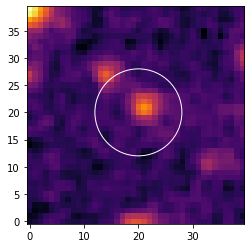

Mean: 59.18598556518555
Median: 55.239479064941406
Std dev: 18.074487686157227
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1   21.1550834339975 ... 3.7166609299495375   -1.42538235581386
  2 14.149801393339708 ... 2.2840538342416044 -0.8967658396071798
  3 0.9823484445374421 ...  8.985027339087349 -2.3837985072287067
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


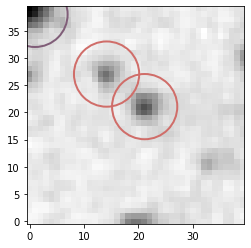

Time taken to fit PSF model: 0.05013349999899219s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


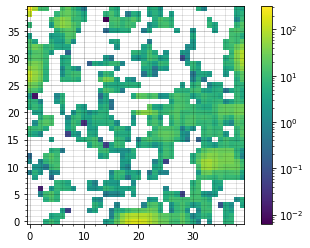

 id group_id iter_detected   x_fit      y_fit   apparent_mag   mag_err  
--- -------- ------------- ---------- --------- ------------ -----------
  1        1             1  21.155083 21.055931    16.469585 0.034143784
  2        1             1  14.149801 27.042401    17.047189 0.041533914
  3        2             1 0.98234844 38.026573    15.707186  0.05731072
id_master    x_0        y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- ---------- --------- --------- ... ----------- --------- -----------
        0  33.096021  10.97261 1003.3595 ...          --        --          --
        1  20.722962 21.194848 990.98647 ... 0.034007806 16.469585 0.034143784
        2  13.911792 26.854897  984.1753 ... 0.043387475 17.047189 0.041533914
        3 0.87539713 37.905959  971.1389 ... 0.057269469 15.707186  0.05731072




Star ID:  1
star_name id_master     RA       dec       x_0       y_0      x_true    y_true   mag_e1     err_e1     mag_e2     err_e2     mag_e3     err_e3   

<ipython-input-16-06d79a6bc74d>:313: RuntimeWarning: invalid value encountered in double_scalars
  var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)


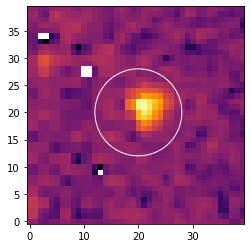

C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


Mean: 51.059391021728516
Median: 49.557464599609375
Std dev: 19.333812713623047
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.189020340222253 ... 21.840863230810935 -3.3481744981963395
  2 2.8687626017854533 ... 1.6299321902204886 -0.5304238422589103
Number of PSF stars: 2


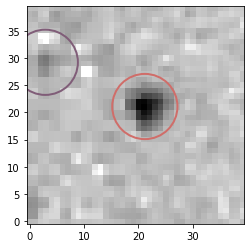

Time taken to fit PSF model: 0.04443399999945541s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


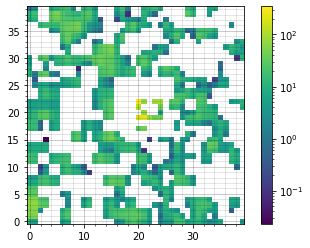

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  21.18902 21.076115    14.516806 0.037288406
  2        2             1 2.8687626 29.211864    17.462696 0.071544604
  3        1             2 21.644665 18.794778    17.330814  0.28236185
id_master    x_0       y_0      x_true  ...    dec      mag_e1     err_e1  
--------- --------- --------- --------- ... --------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 12.824088 14.516806 0.037288406
        0 21.183169 20.559066 690.84945 ... 12.824088 17.330814  0.28236185
        1 2.8432251 28.553037 672.50951 ...   12.8264 17.462696 0.071544604
        2 13.281247 30.217203 682.94753 ... 12.824687        --          --






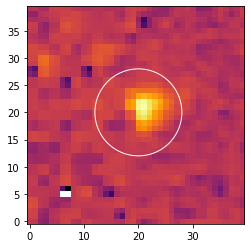

Mean: 53.23928451538086
Median: 51.446617126464844
Std dev: 20.055278778076172
sources_PSF:   id     xcentroid     ...        flux              mag        
--- ----------------- ... ----------------- ------------------
  1 21.00613372840135 ... 22.61120407888789 -3.385809224405338
Number of PSF stars: 1


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


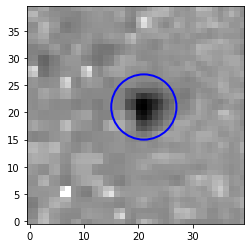

Time taken to fit PSF model: 0.042121899999983725s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


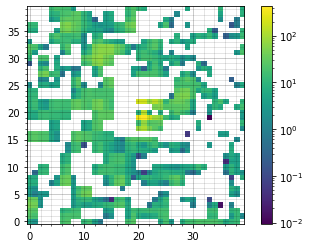

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.006134 20.987076    14.507736 0.037634508
  2        1             2 2.9305775 29.300908    17.571361 0.073715329
id_master    x_0       y_0      x_true  ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.037288406 14.507736 0.037634508
        0 21.183169 20.559066 690.84945 ...  0.28236185 14.507736 0.037634508
        1 2.8432251 28.553037 672.50951 ... 0.071544604 17.571361 0.073715329
        2 13.281247 30.217203 682.94753 ...          --        --          --






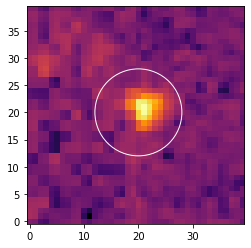

Mean: 59.34831619262695
Median: 56.16853332519531
Std dev: 21.81761360168457
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 21.025779388477293 ... 20.010807076589938   -3.253161512425238
  2    2.6359420332296 ... 1.3367246720110015 -0.31510490981560957
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


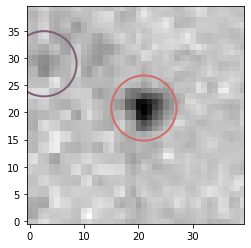

Time taken to fit PSF model: 0.034684500000366825s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


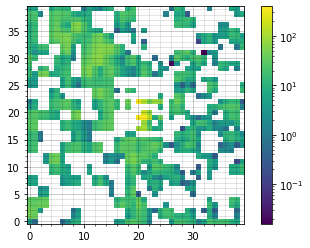

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.025779 20.787146     14.51966 0.036638244
  2        2             1  2.635942 28.938076    17.313968 0.074863022
id_master    x_0       y_0      x_true  ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.037634508  14.51966 0.036638244
        0 21.183169 20.559066 690.84945 ... 0.037634508  14.51966 0.036638244
        1 2.8432251 28.553037 672.50951 ... 0.073715329 17.313968 0.074863022
        2 13.281247 30.217203 682.94753 ...          --        --          --






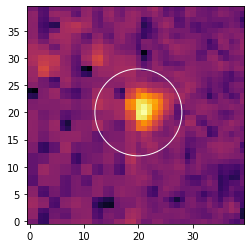

Mean: 54.250579833984375
Median: 51.79446029663086
Std dev: 22.13328742980957
sources_PSF:   id     xcentroid     ...        flux                mag        
--- ----------------- ... ------------------ -------------------
  1  20.9330520729699 ...  19.65119445401478  -3.233472382837369
  2 2.693818010851095 ... 1.3490816573383175 -0.3250955937093245
  3 12.93737068139903 ... 1.2664629445450948 -0.2564812182121536
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


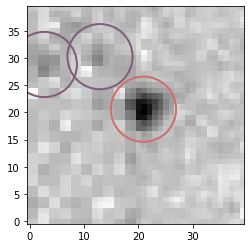

Time taken to fit PSF model: 0.03858089999994263s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


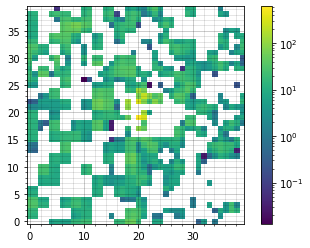

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 20.933052 20.573831    14.527998 0.037731773
  2        2             1  2.693818 28.803493    17.331449 0.068718763
  3        2             1 12.937371 30.247244    17.622603 0.082195407
id_master    x_0       y_0      x_true  ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.036638244 14.527998 0.037731773
        0 21.183169 20.559066 690.84945 ... 0.036638244 14.527998 0.037731773
        1 2.8432251 28.553037 672.50951 ... 0.074863022 17.331449 0.068718763
        2 13.281247 30.217203 682.94753 ...          -- 17.622603 0.082195407






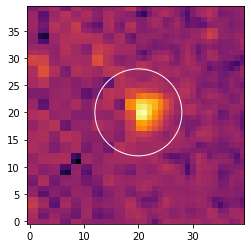

Mean: 56.21854019165039
Median: 52.749725341796875
Std dev: 22.333560943603516
sources_PSF:   id     xcentroid     ...        flux                mag         
--- ----------------- ... ------------------ --------------------
  1 20.93544968365924 ... 20.804441090749886  -3.2953901325185635
  2 12.91319262577169 ... 1.1611367526361371 -0.16220842922960968
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


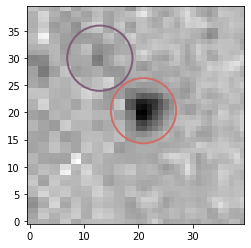

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.12484260000019276s


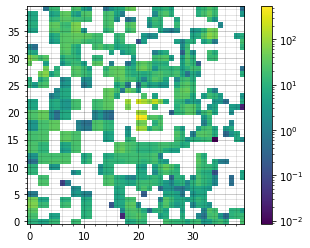

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1  20.93545  20.30952    14.508389 0.037793622
  2        2             1 12.913193 29.960118    17.543374 0.082910744
  3        1             2 2.0112979 28.360955    17.468905 0.080344239
id_master    x_0       y_0      x_true  ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.037731773 14.508389 0.037793622
        0 21.183169 20.559066 690.84945 ... 0.037731773 14.508389 0.037793622
        1 2.8432251 28.553037 672.50951 ... 0.068718763 17.468905 0.080344239
        2 13.281247 30.217203 682.94753 ... 0.082195407 17.543374 0.082910744






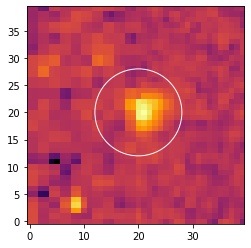

Mean: 56.18647003173828
Median: 53.09473419189453
Std dev: 23.62186050415039
sources_PSF:   id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 1.0901194029081187 ... 1.0417397340856087 -0.044398073394587956
  2 20.956963105037826 ... 18.950128090069114   -3.1940303746285914
  3  2.874293570001577 ...  1.261562188475894   -0.2522716596195719
  4 13.163147665048799 ...  1.165415245894293   -0.1662017380159567
Number of PSF stars: 4


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


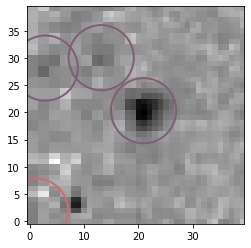

Time taken to fit PSF model: 0.049196300000403426s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


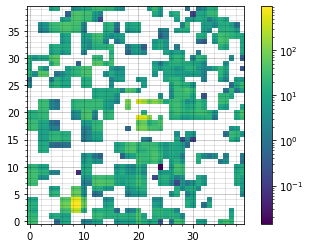

 id group_id iter_detected   x_fit     y_fit   apparent_mag  mag_err  
--- -------- ------------- --------- --------- ------------ ----------
  1        1             1 1.0901194 1.8595136    18.885141 0.34820074
  2        2             1 20.956963 20.304417    14.543799 0.03362993
  3        2             1 2.8742936 28.139551    17.500475 0.25536869
  4        2             1 13.163148 30.053601    17.591629 0.29088128
id_master    x_0       y_0      x_true  ...    err_e5     mag_e6    err_e6  
--------- --------- --------- --------- ... ----------- --------- ----------
        0 21.183169 20.559066 690.84945 ... 0.037793622 14.543799 0.03362993
        0 21.183169 20.559066 690.84945 ... 0.037793622 14.543799 0.03362993
        1 2.8432251 28.553037 672.50951 ... 0.080344239 17.500475 0.25536869
        2 13.281247 30.217203 682.94753 ... 0.082910744 17.591629 0.29088128






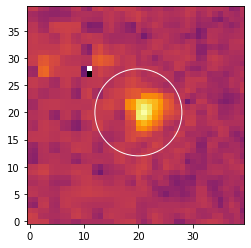

Mean: 57.669281005859375
Median: 55.32465744018555
Std dev: 20.614940643310547
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.077810637954652 ...  23.15790837725507  -3.411748328351194
  2 2.8930243160222724 ... 1.6689011746830444 -0.5560765508644573
  3 13.425452540954714 ... 1.4242942006337906 -0.3839992648864582
Number of PSF stars: 3


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


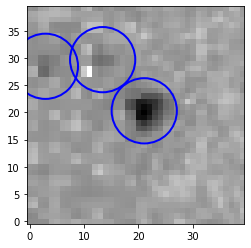

Time taken to fit PSF model: 0.038504600001033396s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


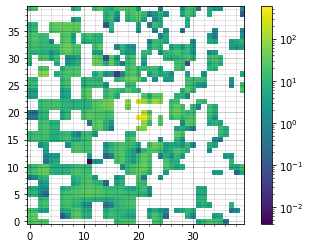

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.077811 20.285963    14.480351 0.033044054
  2        1             1 2.8930243 28.474592     17.40926  0.21561601
  3        1             1 13.425453  29.69667    17.703744  0.30696115
id_master    x_0       y_0      x_true  ...   err_e6     mag_e7     err_e7  
--------- --------- --------- --------- ... ---------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.03362993 14.480351 0.033044054
        0 21.183169 20.559066 690.84945 ... 0.03362993 14.480351 0.033044054
        1 2.8432251 28.553037 672.50951 ... 0.25536869  17.40926  0.21561601
        2 13.281247 30.217203 682.94753 ... 0.29088128 17.703744  0.30696115






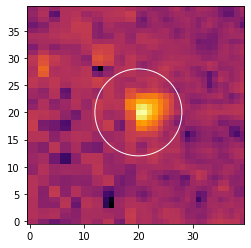

Mean: 50.89241409301758
Median: 48.21837615966797
Std dev: 21.102094650268555
sources_PSF:   id     xcentroid     ...        flux                mag         
--- ----------------- ... ------------------ --------------------
  1 20.93256455601101 ...  24.78450688866666   -3.485450706563542
  2  13.2695072073306 ... 1.4003623624881423 -0.36560107431386996
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


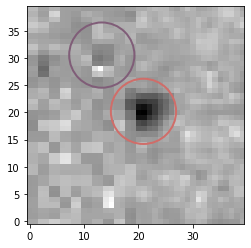

Time taken to fit PSF model: 0.0444063000013557s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


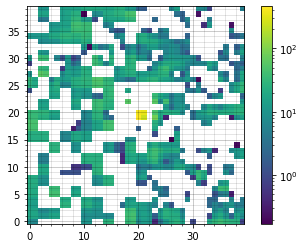

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 20.932565 20.185183    14.434938 0.038181066
  2        2             1 13.269507 30.535693    17.667742 0.095195959
  3        1             2 2.5483483  28.19289    17.189558 0.064852903
id_master    x_0       y_0      x_true  ...    err_e7     mag_e8     err_e8  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.033044054 14.434938 0.038181066
        0 21.183169 20.559066 690.84945 ... 0.033044054 14.434938 0.038181066
        1 2.8432251 28.553037 672.50951 ...  0.21561601 17.189558 0.064852903
        2 13.281247 30.217203 682.94753 ...  0.30696115 17.667742 0.095195959






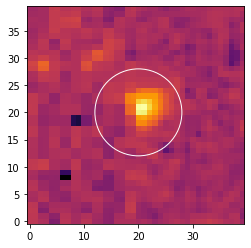

Mean: 64.07093811035156
Median: 61.21665954589844
Std dev: 21.376182556152344
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  20.87237479506515 ...  25.29779121714732 -3.5077065100462015
  2 2.4495481934034418 ... 1.9487605924238525  -0.724396221991574
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


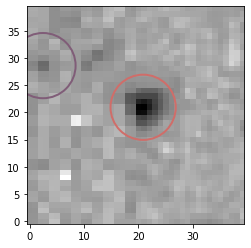

Time taken to fit PSF model: 0.0360435000002326s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


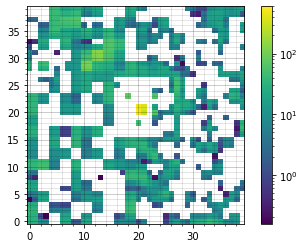

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 20.872375 20.932801    14.358498 0.039877757
  2        2             1 2.4495482 28.599777    17.221682 0.059839591
id_master    x_0       y_0      x_true  ...    err_e8     mag_e9     err_e9  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.038181066 14.358498 0.039877757
        0 21.183169 20.559066 690.84945 ... 0.038181066 14.358498 0.039877757
        1 2.8432251 28.553037 672.50951 ... 0.064852903 17.221682 0.059839591
        2 13.281247 30.217203 682.94753 ... 0.095195959        --          --






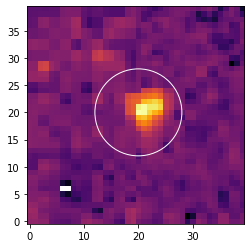

Mean: 56.65727233886719
Median: 54.588966369628906
Std dev: 18.96562385559082
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1   1.52074666567046 ... 1.1141373139293174 -0.11734679892270042
  2 2.5258846034715114 ...  1.993412700785705  -0.7489930524700471
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


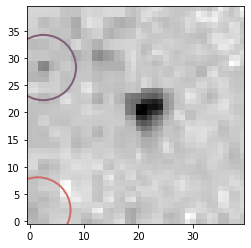

Time taken to fit PSF model: 0.03281500000048254s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


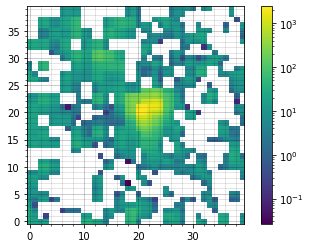

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 1.5207467 2.0522234    18.566746  0.19322455
  2        2             1 2.5258846 28.250584    17.430838 0.074988206
id_master    x_0       y_0      x_true  ...    err_e9    mag_e10    err_e10  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.039877757        --          --
        0 21.183169 20.559066 690.84945 ... 0.039877757        --          --
        1 2.8432251 28.553037 672.50951 ... 0.059839591 17.430838 0.074988206
        2 13.281247 30.217203 682.94753 ...          --        --          --






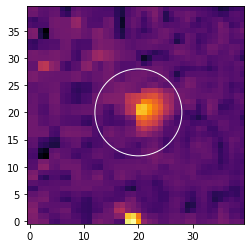

Mean: 59.39976501464844
Median: 56.65270233154297
Std dev: 19.780723571777344
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1.3794158267771948 ...  1.120502740795402 -0.12353230793598506
  2  21.07589796970497 ... 25.068501526491247   -3.497820936787649
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


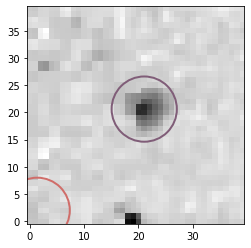

Time taken to fit PSF model: 0.03722909999851254s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


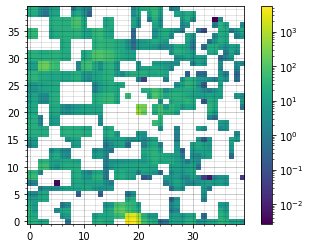

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 1.3794158 1.9828743     18.53715  0.15438836
  2        2             1 21.075898 20.600404    14.437057 0.039918639
id_master    x_0       y_0      x_true  ...   err_e10    mag_e11    err_e11  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ...          -- 14.437057 0.039918639
        0 21.183169 20.559066 690.84945 ...          -- 14.437057 0.039918639
        1 2.8432251 28.553037 672.50951 ... 0.074988206        --          --
        2 13.281247 30.217203 682.94753 ...          --        --          --






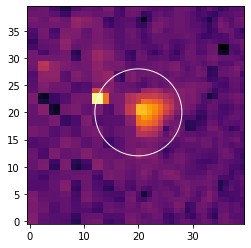

Mean: 58.67653274536133
Median: 56.80615234375
Std dev: 20.936443328857422
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 21.269803647096097 ... 20.232983653319923  -3.265149826628787
  2 3.0274792680071267 ...  1.575859034158324 -0.4937934145061568
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


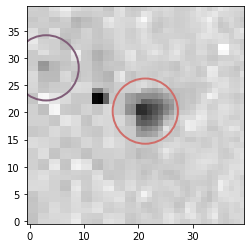

Time taken to fit PSF model: 0.03576310000062222s


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


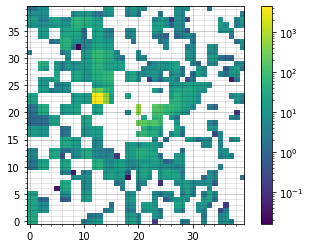

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 21.269804 20.228308    14.506134 0.040047145
  2        2             1 3.0274793 28.188978    17.500597 0.083826891
id_master    x_0       y_0      x_true  ...   err_e11    mag_e12    err_e12  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 21.183169 20.559066 690.84945 ... 0.039918639 14.506134 0.040047145
        0 21.183169 20.559066 690.84945 ... 0.039918639 14.506134 0.040047145
        1 2.8432251 28.553037 672.50951 ...          -- 17.500597 0.083826891
        2 13.281247 30.217203 682.94753 ...          --        --          --




Star ID:  0
star_name id_master     RA       dec       x_0       y_0      x_true    y_true    mag_e1     err_e1     mag_e2     err_e2    mag_e3     err_e3     mag_e4     err_e4     mag_e5     err_e5     mag_e6    err_e6     mag_e7     err_e

<Table length=5>
star_name   id_master        RA    ...         IQR               chi_sq      
  str10       int32       float64  ...       float64            float64      
--------- -------------- --------- ... ------------------- ------------------
     RRL0              2  346.6729 ...   0.190174301310158 111.97863867238496
     RRL1              1 346.68512 ... 0.13818529848996164  66.55609315558254
     RRL2              1 346.67961 ... 0.21334335606415777  190.2430713894951
     RRL3 -2.1474836e+09       nan ...                 nan                nan
     RRL4              0 346.65532 ... 0.08223568635837353 20.148470438756682

In [16]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

big_table = Table()  # initialising the table we'll dump each RRL's data into
# Ideal order for column names (also used to initialise blank rows for missing stars):
new_order = ['star_name', 'id_master', 'RA', 'dec', 'x_0', 'y_0', 'x_true', 'y_true', 'mag_e1', 'err_e1', 'mag_e2', 'err_e2', 'mag_e3', 'err_e3', 'mag_e4', 'err_e4', 'mag_e5', 'err_e5', 'mag_e6', 'err_e6', 'mag_e7', 'err_e7', 'mag_e8', 'err_e8', 'mag_e9', 'err_e9', 'mag_e10', 'err_e10', 'mag_e11', 'err_e11', 'mag_e12', 'err_e12', 'eta_inv', 'IQR', 'chi_sq']

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        print('Current star: RRL{}'.format(star+1))
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        master_table = Table.read(master_file, format='ascii.csv')
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:  
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+cluster+'__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                if sources_PSF == None:
                    print('No sources found initially :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('No sources found after reducing detection threshold :(')          
                
                try:
                    pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                except TypeError:                    
                    mag_name = 'mag_e'+str(epoch)
                    err_name = 'err_e'+str(epoch)
                    master_table[mag_name] = float('NaN')
                    master_table[err_name] = float('NaN')
                    
                    epoch += 1
                    continue
                
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                #plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_'+channel+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d < max_sep)
            match_table = match_table[selection]
            comp_table = comp_table[idx[selection]]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)
            
            mag_name = 'mag_e'+str(epoch)
            err_name = 'err_e'+str(epoch)
            
            try:
                master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            except ValueError:
                print('RRL{} not detected in this epoch :('.format(star+1))

                master_table[mag_name] = float('NaN')
                master_table[err_name] = float('NaN')

                epoch += 1
                continue
            
            #master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###
        
        ###   CALCULATING VARIABILITY INDICES AND AMPLITUDE FOR EACH STAR   ###
        
        masked_array = np.ma.array(np.zeros(len(master_table)), mask=True)
        master_table['eta_inv'] = masked_array
        master_table['IQR'] = masked_array
        master_table['chi_sq'] = masked_array

        master_table_f = copy.copy(master_table.filled(-99))

        for i in range(len(master_table_f)):

            # Putting magnitudes into an array so we can play with them:
            mags = []
            errs = []
            for j in range(1,13):
                mags.append(master_table_f['mag_e'+str(j)][i])
                errs.append(master_table_f['err_e'+str(j)][i])

            mags = np.ma.array(mags)
            mags = np.ma.masked_where(mags == -99, mags)
            errs = np.ma.array(errs)
            errs = np.ma.masked_where(errs == -99, errs)

            if mags.compressed().size:    # doesn't calculate anything extra if the star has no magnitude data

                # Chi squared test:
                mean_sum1 = sum((m / e**2) for m, e in zip(mags.compressed(), errs.compressed()))
                mean_sum2 = sum((1. / e**2) for e in errs.compressed())
                mean_chi = mean_sum1 / mean_sum2

                chi_sq = sum(((m - mean_chi) / e)**2 for m, e in zip(mags.compressed(), errs.compressed()))
                master_table['chi_sq'][i] = chi_sq

                # IQR:
                mags_sorted = sorted(mags.compressed())
                if len(mags_sorted) > 5:  # finding IQR for fewer than 6 values is pointless really, and can cause issues
                    if len(mags_sorted) % 2 == 1:   # if odd number of entries, remove the median
                        mags_sorted.pop(int(len(mags_sorted)/2))

                    mags_split= np.array_split(mags_sorted, 2)
                    mags_lo = mags_split[0]
                    mags_hi = mags_split[1]

                    n = int(len(mags_lo) / 2)
                    q25 = (mags_lo[n-1] + mags_lo[n]) / 2
                    q75 = (mags_hi[n-1] + mags_hi[n]) / 2
                    iqr = q75 - q25
                    master_table['IQR'][i] = iqr

                # von Neumann index:
                # (VERY important this is run LAST out of all the indices, otherwise 'continue' may skip them)
                var = sum((m - np.mean(mags.compressed()))**2 for m in mags.compressed()) / (len(mags.compressed()) - 1)
                diff = 0
                for k in range(len(mags.compressed()) - 1):
                    diff += (mags.compressed()[k+1] - mags.compressed()[k])**2
                if (len(mags.compressed()) - 1) == 0:
                    continue
                mssd = diff / (len(mags.compressed()) - 1)
                if mssd == 0. or var == 0.:
                    continue
                eta_inv = var / mssd
                master_table['eta_inv'][i] = eta_inv
        
        ###   KEEPING ONLY THE RRL   ###

        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        
        master_table['star_name'] = str('not an RRL')
        master_table['star_name'][star_id] = 'RRL'+str(star)

        master_table = master_table[new_order]
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()
                

        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    
    else:  # i.e. if not in starlist
        
        master_table = Table(data=np.full(shape=len(master_table), fill_value=np.nan, dtype=big_table.dtype), names=new_order, masked=True)
        master_table['star_name'] = 'RRL'+str(star)
        
    
    big_table = vstack([big_table, master_table[star_id]])    
    
    #if star == 1:
    #    break
        
    
    ###   END OF STAR LOOP   ###

save_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table, pickle_out)
pickle_out.close()

big_table

In [15]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'
#load_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

big_table

<Table length=5>
star_name   id_master        RA    ...         IQR               chi_sq      
  str10       int32       float64  ...       float64            float64      
--------- -------------- --------- ... ------------------- ------------------
     RRL0              3  346.6731 ... 0.14524234763840127 140.85730015112927
     RRL1              2  346.6853 ... 0.36570248475341316 240.39049484596677
     RRL2              2  346.6796 ...  0.2919240254844411 175.80550913961633
     RRL3              1 346.70346 ... 0.13741286593406343  92.49132931509716
     RRL4 -2.1474836e+09       nan ...                 nan                nan

In [14]:
loadname0 = 'phot_tables/'+cluster+'/individual/big_table_RRL0_'+method+'_'+channel+'.pickle'
loadname1 = 'phot_tables/'+cluster+'/individual/big_table_RRL1_'+method+'_'+channel+'.pickle'
loadname2 = 'phot_tables/'+cluster+'/individual/big_table_RRL2_'+method+'_'+channel+'.pickle'
loadname3 = 'phot_tables/'+cluster+'/individual/big_table_RRL3_'+method+'_'+channel+'.pickle'
loadname4 = 'phot_tables/'+cluster+'/individual/big_table_RRL4_'+method+'_'+channel+'.pickle'
loadname5 = 'phot_tables/'+cluster+'/individual/big_table_RRL5_'+method+'_'+channel+'.pickle'
loadname6 = 'phot_tables/'+cluster+'/individual/big_table_RRL6_'+method+'_'+channel+'.pickle'

pickle_in = open(loadname0, 'rb')
RRL0 = pickle.load(pickle_in)
pickle_in = open(loadname1, 'rb')
RRL1 = pickle.load(pickle_in)
pickle_in = open(loadname2, 'rb')
RRL2 = pickle.load(pickle_in)
pickle_in = open(loadname3, 'rb')
RRL3 = pickle.load(pickle_in)
pickle_in = open(loadname4, 'rb')
RRL4 = pickle.load(pickle_in)
pickle_in = open(loadname5, 'rb')
RRL5 = pickle.load(pickle_in)
pickle_in = open(loadname6, 'rb')
RRL6 = pickle.load(pickle_in)

In [15]:
RRL6

<Row index=1>
star_name id_master    x_0       y_0       RA        dec       mag_e1     err_e1     mag_e2     err_e2     mag_e3     err_e3     mag_e4     err_e4     mag_e5     err_e5     mag_e6     err_e6    mag_e7  err_e7   mag_e8     err_e8     mag_e9     err_e9    mag_e10   err_e10    mag_e11    err_e11    mag_e12    err_e12   eta_inv   IQR    chi_sq
  str10     int32    float64   float64  float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64    float64   float64 float64  float64    float64    float64    float64    float64   float64    float64    float64    float64    float64   float64 float64 float64
--------- --------- --------- --------- -------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- --------- ----------- ------- ------- --------- ----------- --------- ----------- --------- ---------- --------- ----------- --------- ----------- ------- ------- -------
     RRL6         1 20.254074 20.788959 229.0395 -0.27310464 16.264084 0.040842699 16.327979 0.041777398 15.987809 0.038611594 16.009818 0.047017224 15.981321 0.042920053 16.081061 0.047154087     nan     nan 16.141962 0.045662641 16.171013 0.042628169 16.427533 0.05394822 16.506283 0.049906758 16.016763 0.042596907     nan     nan     nan

### Run this to add Welch-Stetson variability index to huge_table:
Requires data from both channels, hence why this isn't in the main photometry cell

In [17]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'
load_name_normal = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)
pickle_in = open(load_name_normal, 'rb')
big_table = pickle.load(pickle_in)

'''ra1 = np.ma.masked_invalid(big_table_ch1['RA'])
dec1 = np.ma.masked_invalid(big_table_ch1['dec'])
ra2 = np.ma.masked_invalid(big_table_ch2['RA'])
dec2 = np.ma.masked_invalid(big_table_ch2['dec'])
print(ra1.compressed(), dec1.compressed(), ra2.compressed(), dec2.compressed())

cat_ch1 = SkyCoord(ra1.compressed(), dec1.compressed(), frame='icrs', unit='deg')
cat_ch2 = SkyCoord(ra2.compressed(), dec2.compressed(), frame='icrs', unit='deg')

idx, d2d, d3d = match_coordinates_sky(cat_ch1, cat_ch2)  # idx correspond to ch1

#print(len(idx))
#print(len(cat_ch1))

max_sep = 0.4 * u.arcsec  # looking at maximum distance between matching RA/dec coords, around 0.4 seems to work decently
selection = (d2d > max_sep)
match_index = idx
match_index[selection] = -99.
ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

big_table_ch1 = big_table_ch1[ind]
big_table_ch2 = big_table_ch2[match_index][ind]
#print(len(big_table_ch1))

id_list = np.arange(len(big_table_ch1))
big_table_ch1['id_match'] = id_list
big_table_ch2['id_match'] = id_list'''

masked_array = np.ma.array(np.zeros(len(big_table_ch1)), mask=True)
big_table_ch1['I_var'] = masked_array
big_table_ch2['I_var'] = masked_array

big_table_ch1_f = copy.copy(big_table_ch1.filled(-99))
big_table_ch2_f = copy.copy(big_table_ch2.filled(-99))

for i in range(len(big_table_ch1)):
    #print(i)
    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        mags_ch1.append(big_table_ch1_f['mag_e'+str(j)][i])
        mags_ch2.append(big_table_ch2_f['mag_e'+str(j)][i])
        errs_ch1.append(big_table_ch1_f['err_e'+str(j)][i])
        errs_ch2.append(big_table_ch2_f['err_e'+str(j)][i])

    mags_ch1 = np.ma.array(mags_ch1)
    mags_ch1 = np.ma.masked_where(mags_ch1 == -99, mags_ch1)
    mags_ch2 = np.ma.array(mags_ch2)
    mags_ch2 = np.ma.masked_where(mags_ch2 == -99, mags_ch2)
    errs_ch1 = np.ma.array(errs_ch1)
    errs_ch1 = np.ma.masked_where(errs_ch1 == -99, errs_ch1)
    errs_ch2 = np.ma.array(errs_ch2)
    errs_ch2 = np.ma.masked_where(errs_ch2 == -99, errs_ch2)
    
    m1_mean = np.mean(mags_ch1.compressed())
    m2_mean = np.mean(mags_ch2.compressed())
    n = len(mags_ch1)   # could also be len(mags_ch2)
    
    # probably need to do a for loop instead of list comprehension
    # check if number of mags in ch1 and ch2 list match; if not, don't calculate
    # doesn't guarantee that the mags are from the same epochs, even if the length matches; might need to only calculate for stars with 12 observations :/
    # unless we wanna get complicated and check that each list has values in the same places
    
    '''if len(mags_ch1.compressed()) == 12 and len(mags_ch2.compressed()) == 12:
        count += 1
        print('yay they are both big')
        
        I = sum((((m1-m1_mean)/e1) * ((m2-m2_mean)/e2)) for m1, m2, e1, e2 in zip(mags_ch1, mags_ch2, errs_ch1, errs_ch2)) * np.sqrt(1. / (n*(n-1)))

        print(len(mags_ch1.compressed()))
        print(len(mags_ch2.compressed()))
        print('I: ', I, '\n')

        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I'''
    
    I_prod = 0
    count_unmasked = 0
    
    for k in range(len(mags_ch1)):
        if np.ma.is_masked(mags_ch1[k]) == True:
            #print('ch1 is masked')
            continue
        elif np.ma.is_masked(mags_ch2[k]) == True:
            #print('ch2 is masked')
            continue
        else:
            #print('neither masked :)')
            count_unmasked += 1
            I_prod += ((mags_ch1[k] - m1_mean) / errs_ch1[k]) * ((mags_ch2[k] - m2_mean) / errs_ch2[k])
        
    #print('count unmasked: ', count_unmasked)
    if count_unmasked > 5:
        I = I_prod * np.sqrt(1. / n * (n - 1))
        #print('I: ', I)
        big_table_ch1['I_var'][i] = I
        big_table_ch2['I_var'][i] = I
    #else:
        #print('too few good values to calculate I :(')
    
    #print(big_table_ch1['I_var'][i])
    #print('\n')


big_table_var = join(big_table, big_table_ch1['star_name', 'I_var'], keys='star_name', join_type='left')

save_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'
pickle_out = open(save_name, 'wb')
pickle.dump(big_table_var, pickle_out)
pickle_out.close()

big_table_var

<Table length=5>
star_name   id_master        RA    ...       chi_sq              I_var       
  str10       int32       float64  ...      float64             float64      
--------- -------------- --------- ... ------------------ -------------------
     RRL0              2  346.6729 ... 111.97863867238496   55.13041941431693
     RRL1              1 346.68512 ...  66.55609315558254 -10.376788119417483
     RRL2              1 346.67961 ...  190.2430713894951    14.7638680268631
     RRL3 -2.1474836e+09       nan ...                nan                 nan
     RRL4              0 346.65532 ... 20.148470438756682                 nan

### Plotting light curves:

In [156]:
big_table_f

<Table length=7>
star_name   id_master        RA    ...       chi_sq              I_var        
  str10       int32       float64  ...      float64             float64       
--------- -------------- --------- ... ------------------ --------------------
     RRL0              2  228.9883 ...  40.74516374693197     7.15097866283335
     RRL1 -2.1474836e+09       nan ...                nan                  nan
     RRL2              1 229.05319 ...                nan                  nan
     RRL3 -2.1474836e+09       nan ...                nan                  nan
     RRL4              0 228.99257 ...   52.5539288907453    9.076202419186659
     RRL5              1 228.99621 ... 0.7589534478039934 -0.04090589973405752
     RRL6 -2.1474836e+09       nan ...                nan                  nan

RRab
Mags:  [15.891553654635764 15.93655565700395 15.938441794833318
 15.994236309351512 15.95941409682088 15.938731135992395 15.93602900762312
 15.945855631603752 15.907345478776943 15.949550622798668
 15.949901963661098 15.842399541642337]
Errs:  [0.31408940075966696 0.3220570271331383 0.3117801572230062
 0.30377007373799525 0.3735147275978191 0.3387196488104105
 0.3281156398683292 0.36221042409776566 0.43654625189887086
 0.39827039033749184 0.37775289201885776 0.2891523256597548]
Phase:  [0.3765373656497104 0.48631934908917174 0.5690535252506379
 0.6674239707936067 0.7636280783772236 0.8677452556148637
 0.9477804612106411 0.04827366388053633 0.1448888923623599
 0.2294763514364604 0.3240366951795295 0.43251251327455975]


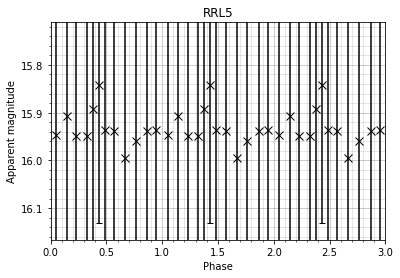

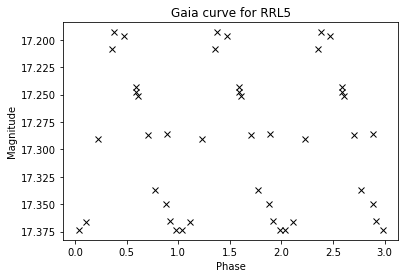

Chi squared:   0.16962559694517254
IQR:           0.028039050029851964
Welch-Stetson: -0.04090589973405752
von Neumann:   0.729626323823537


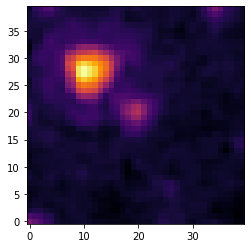

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


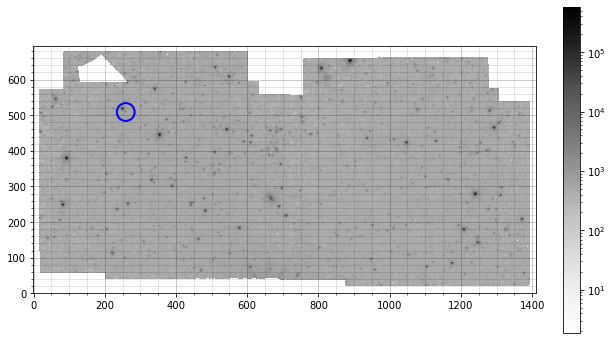

In [12]:
load_name = 'phot_tables/'+cluster+'/individual/big_table_var_'+method+'_'+channel+'.pickle'

pickle_in = open(load_name, 'rb')
big_table = pickle.load(pickle_in)

LC_time = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


###   FOR PLOTTING STAR FROM CATALOGUE   ###

###########
star_id = 5
###########

if star_id in starlist:

    file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
    df_CC = pd.read_csv(file_CC, sep=',', header=0)
    
    #c_CC = SkyCoord(df_CC['RA'][star_id], df_CC['dec'][star_id], frame='icrs', unit='deg')
    ra_temp = np.ma.masked_invalid(big_table['RA'])
    dec_temp = np.ma.masked_invalid(big_table['dec'])
    #c_comp = SkyCoord(ra_temp.compressed(), dec_temp.compressed(), frame='icrs', unit='deg')

    if df_CC['type'][star_id] == 'RR0':
        P = df_CC['period_fund'][star_id]
        print('RRab')
    elif df_CC['type'][star_id] == 'RR1':
        P = df_CC['period_FO'][star_id]
        print('RRc')
    elif df_CC['type'][star_id] == 'RR01':
        P = df_CC['period_FO'][star_id]

    temp = [i / P for i in LC_time]
    phase = temp - np.floor(temp)  


    #big_table_i = big
    big_table_f = copy.copy(big_table.filled(-99))

    mags = []
    errs = []
    for i in range(1,13):
        mags.append(big_table['mag_e'+str(i)][star_id])
        errs.append(big_table['err_e'+str(i)][star_id])

    ### Masking out a specific data point (only use in emergencies, or the Science Police will get you):

    #remove_pls = 5  # EPOCH number of bad point
    #mags[remove_pls-1] = -99
    #print(mags)

    ###

    mags = np.ma.array(mags)
    #mags = np.ma.masked_where(mags == -99, mags)
    mags = np.ma.masked_invalid(mags)
    errs = np.ma.masked_array(errs, mags.mask)
    phase = np.ma.masked_array(phase, mags.mask)
    print('Mags: ', mags)
    print('Errs: ', errs)
    print('Phase: ', phase)

    ###   PLOTTING LIGHT CURVES   ###

    mags_long = np.ma.concatenate((mags, mags, mags))  # this idea taken from some of vicky's code; credit?
    errs_long = np.ma.concatenate((errs, errs, errs))
    phase_long = np.ma.concatenate((phase, phase + 1., phase + 2.))

    plt.errorbar(phase_long, mags_long, yerr=errs_long, fmt='x', color='black', capsize=3, markersize=8)
    plt.ylim(np.ma.median(mags) - 1.5*(max(mags)-min(mags)), np.ma.median(mags) + 1.5*(max(mags)-min(mags)))
    plt.xlim(0, 3)
    plt.gca().invert_yaxis()
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.xlabel('Phase')
    plt.ylabel('Apparent magnitude')
    plt.title('RRL'+str(star_id))
    #plt.savefig('images/'+cluster+'/curves/'+method+'_'+channel+'_'+str(star_id)+'_'+str(model_epoch)+'.png', dpi=100)
    plt.show()

    ###   GAIA DR2 CURVE COMPARISON   ###

    vot_name = 'data/curves/proc_RRL'+str(star_id+1)+'.vot'

    if os.path.isfile(vot_name) == True:

        votable = parse_single_table(vot_name)
        data_vot = votable.array

        temp = [i / P for i in data_vot['obs_time']]
        phase_vot = temp - np.floor(temp)

        mags_vot = np.concatenate((data_vot['phot'], data_vot['phot'], data_vot['phot']))
        phases_vot = np.concatenate((phase_vot, phase_vot + 1., phase_vot + 2.))

        plt.plot(phases_vot, mags_vot, 'kx')
        plt.xlabel('Phase')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        plt.title('Gaia curve for RRL'+str(star_id))
        #plt.savefig('images/'+cluster+'/curves/gaia/RRL'+str(star_id+1), dpi=200)
        plt.show()

    ###   PRINTING VARIABILITY INFORMATION ETC.   ###

    print('Chi squared:  ', big_table['chi_sq'][star_id])
    print('IQR:          ', big_table['IQR'][star_id])
    print('Welch-Stetson:', big_table['I_var'][star_id])
    print('von Neumann:  ', big_table['eta_inv'][star_id])

    ###   PLOTTING IMAGE OF STAR FROM MASTER FRAME   ###

    star_r = 20
    star_x = int(big_table['x_true'][star_id])
    star_y = int(big_table['y_true'][star_id])
    star_ap = CircularAperture((star_x, star_y), r=25.)

    region = data_m[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
    plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
    #star_ap.plot(color='white')
    plt.show()

    plt.imshow(data_m, cmap='Greys', origin='lower', norm=LogNorm(), interpolation='nearest')
    star_ap.plot(color='blue', lw=2.)
    plt.colorbar(fraction = 0.05)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    plt.gcf().set_size_inches(10, 6)
    plt.show()

    #plotting(data_m, star_ap, an=None, cmap='Greys', choice='ap_only', savename=None)
    
else:
    print("RRL"+str(star_id)+" isn't visible in this channel")

### Running GLOESS:

In [197]:
big_table_ch1

<Table length=7>
star_name   id_master        RA    ...         IQR               chi_sq      
  str10       int32       float64  ...       float64            float64      
--------- -------------- --------- ... ------------------- ------------------
     RRL0              2  228.9883 ... 0.12266601339165106  40.74516374693197
     RRL1 -2.1474836e+09       nan ...                 nan                nan
     RRL2              1 229.05319 ... 0.08364764593109086                nan
     RRL3 -2.1474836e+09       nan ...                 nan                nan
     RRL4              0 228.99257 ... 0.08597920367054357   52.5539288907453
     RRL5              1 228.99621 ... 0.06817544820642141 0.7589534478039934
     RRL6 -2.1474836e+09       nan ...                 nan                nan

Gaia DR2 ID: 4418914863842345856
RRc
Channel 1 mags:  [16.46457961 16.41590768 16.32487826 16.40188227 16.467235   16.53119619
 16.31903277 16.3605872  16.49983239 16.50150452 16.49631416 16.39022732]
Channel 2 mags:  [16.5074408  16.42071801 16.5017606  16.41617999 16.43254054 16.45774974
 16.46116032 16.36783037 16.45456473 16.51755404 16.52264787 16.41297726] 

RRL1 ---- Period = 0.29322862 days
------------------------------------------------------
12 12
<[3.6]> = 16.431    std dev = 0.056     amplitude = 0.155
<[4.5]> = 16.454    std dev = 0.025     amplitude = 0.074
<[3.6] - [4.5]> = -0.023    std dev = 0.039     amplitude = 0.118
16.730520775764372
16.13052077576437


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


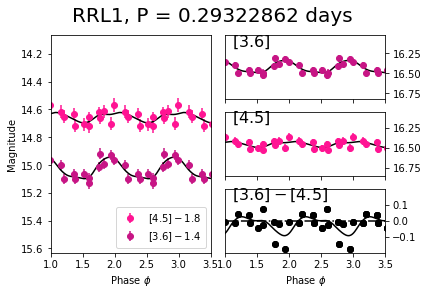




Gaia DR2 ID: 4418913218870688768
RRd
Channel 1 mags:  []
Channel 2 mags:  [16.26462683 16.2422049  16.29573522 16.28694644 16.27944953 16.26957424
 16.27103321 16.31167318 16.19334307 16.22813418 16.21146509 16.2367441 ] 

RRL2 ---- Period = 0.33245990000000003 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.257    std dev = 0.013     amplitude = 0.040
Channels don't have the same number of measurements, so colour curve couldn't be plotted


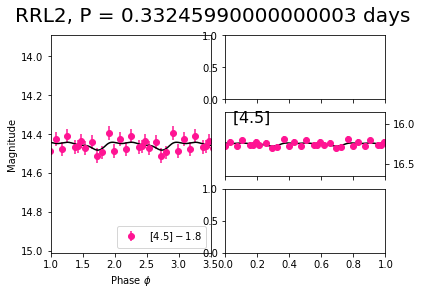




Gaia DR2 ID: 441872602716125056
RRc
Channel 1 mags:  [16.44881767 16.42010076 16.357244   16.36946057 16.34378917 16.45985185
 16.61076997 99.         16.41116571 16.45797594 16.42244743 16.38107193]
Channel 2 mags:  [16.74510759 16.46784714 16.45204754 16.46064889 16.39244578 99.
 99.         99.         99.         16.384485   16.42496412 16.37304486] 

RRL3 ---- Period = 0.32994609999999996 days
------------------------------------------------------
11 8


C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\type_check.py:462: UserWarning: Warning: converting a masked element to nan.
  x = _nx.array(x, subok=True, copy=copy)


<[3.6]> = 16.420    std dev = 0.038     amplitude = 0.122
<[4.5]> = 16.458    std dev = 0.040     amplitude = 0.148
Channels don't have the same number of measurements, so colour curve couldn't be plotted


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


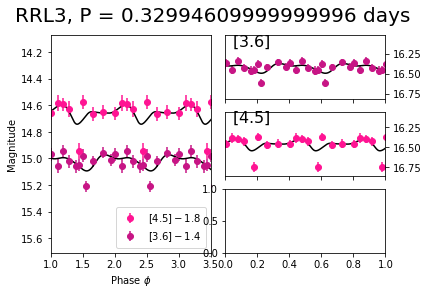




RRc
Channel 1 mags:  []
Channel 2 mags:  [16.48812639 16.40419414 16.47003671 16.47712258 16.40169962 16.50150981
 16.37507725 16.42292839 16.47882147 16.46813403 16.44011712 16.42368005] 

RRL4 ---- Period = 0.2864 days
------------------------------------------------------
0 12


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.447    std dev = 0.021     amplitude = 0.072
Channels don't have the same number of measurements, so colour curve couldn't be plotted


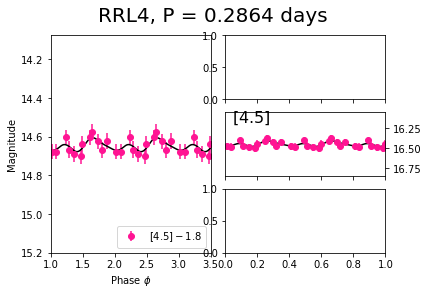




Gaia DR2 ID: 4418920808077110784
RRc
Channel 1 mags:  [16.32266747 16.33928474 16.39819875 16.4639766  16.22488658 16.38019195
 16.37570675 16.49374695 16.36872685 16.28341195 16.41037147 16.42353915]
Channel 2 mags:  [16.30306196 16.43908569 16.3723099  16.35937744 16.3012713  16.33584757
 16.40770798 16.4183386  16.46870454 16.4100489  16.39090231 16.37287038] 

RRL5 ---- Period = 0.33793290000000004 days
------------------------------------------------------
12 12
<[3.6]> = 16.369    std dev = 0.036     amplitude = 0.120


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.383    std dev = 0.030     amplitude = 0.082
<[3.6] - [4.5]> = -0.014    std dev = 0.025     amplitude = 0.089
16.66933658453324
16.06933658453324


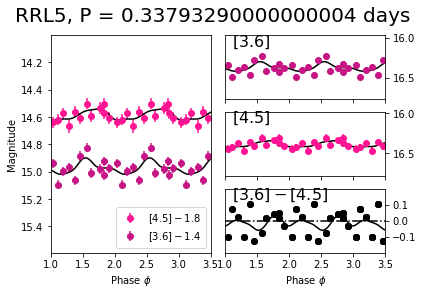




Gaia DR2 ID: 4418920846732620032
RRab
Channel 1 mags:  [16.00751676 16.00483073 16.08457846 15.98693717 15.82442787 15.96054524
 15.9832218  15.92943892 16.02580253 15.95722185 15.91157446 15.94655768]
Channel 2 mags:  [15.89155365 15.93655566 15.93844179 15.99423631 15.9594141  15.93873114
 15.93602901 15.94585563 15.90734548 15.94955062 15.94990196 15.84239954] 

RRL6 ---- Period = 0.64322793 days
------------------------------------------------------
12 12
<[3.6]> = 15.968    std dev = 0.033     amplitude = 0.124
<[4.5]> = 15.936    std dev = 0.024     amplitude = 0.085
<[3.6] - [4.5]> = 0.032    std dev = 0.047     amplitude = 0.169

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



16.268232300012954
15.668232300012953


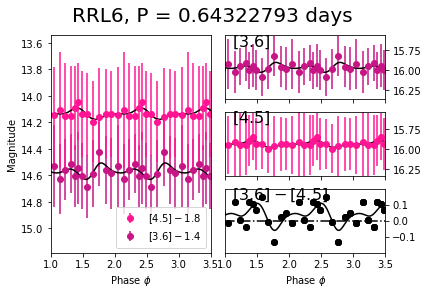




Gaia DR2 ID: 4418724034151291776
RRab
Channel 1 mags:  []
Channel 2 mags:  [16.26408443 16.3279792  15.98780904 16.00981829 15.98132064 16.08106136
 99.         16.14196171 16.17101296 16.42753348 16.50628336 16.01676306] 

RRL7 ---- Period = 0.551705 days
------------------------------------------------------
0 11


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<[4.5]> = 16.133    std dev = 0.125     amplitude = 0.399
Channels don't have the same number of measurements, so colour curve couldn't be plotted


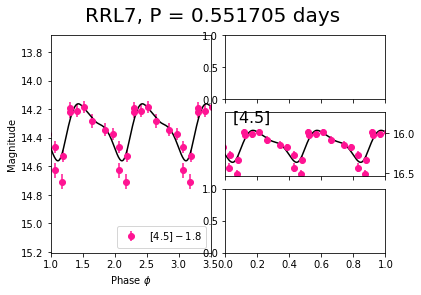

ID            RA           dec units  period_fund  period_FO  mean_mag_CC  \
0   1  15h15m57.18s  -00d06m53.3s    R0          NaN   0.293229      17.7100   
1   2  15h15m57.95s  -00d11m23.4s    R0     0.456049   0.332460      17.8100   
2   3  15h16m12.76s  -00d10m03.3s    R0          NaN   0.329946      17.7000   
3   4  15h16m05.79s  -00d11m12.7s    R0          NaN   0.286400      17.6900   
4   5  15h15m58.23s  -00d05m47.4s    R0          NaN   0.337933      17.7000   
5   6     228.99635      -0.08978    R0     0.643228        NaN      17.2908   
6   7     229.03964   -0.27308442    R0     0.551705        NaN          NaN   

   amplitude colour  type  ...  mean_mag_ch1  mean_mag_ch2  mean_std_ch1  \
0       0.42      B   RR1  ...     16.420521     16.445960      0.056273   
1       0.40      B  RR01  ...           NaN     16.248754           NaN   
2       0.50      B   RR1  ...     16.410058     16.450262      0.038163   
3       0.48      B   RR1  ...           NaN     16.439199           NaN   
4       0.30      B   RR1  ...     16.359337     16.375117      0.036339   
5        NaN    NaN   RR0  ...     15.958232     15.927798      0.032613   
6       1.14    NaN   RR0  ...           NaN     16.125024           NaN   

   mean_std_ch2  mean_photerr_ch1  mean_photerr_ch2  period_used  period_PL  \
0      0.024742          0.037683          0.045727     0.293229   0.392832   
1      0.012662               NaN          0.035908     0.332460   0.445389   
2      0.039588          0.045955          0.054839     0.329946   0.442021   
3      0.021242               NaN          0.039866     0.286400   0.383683   
4      0.030286          0.034494          0.042280     0.337933   0.452721   
5      0.024077          0.254186          0.346332     0.643228   0.643228   
6      0.125448               NaN          0.044824     0.551705   0.551705   

   A_ch1  A_ch2  
0   0.01  0.008  
1   0.01  0.008  
2   0.01  0.008  
3   0.01  0.008  
4   0.01  0.008  
5   0.01  0.008  
6   0.01  0.008  

[7 rows x 23 columns]

In [5]:
load_name_ch1 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_3p6um.pickle'
load_name_ch2 = 'phot_tables/'+cluster+'/individual/big_table_all_'+method+'_4p5um.pickle'

pickle_in = open(load_name_ch1, 'rb')
big_table_ch1 = pickle.load(pickle_in)
pickle_in = open(load_name_ch2, 'rb')
big_table_ch2 = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
df_CC = pd.read_csv(file_CC, sep=',', header=0)

LC_time_gloess = []
for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    with fits.open(filename) as hdu_list:        
        hdr = hdu_list[0].header
    LC_time_gloess.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)


ch1_smooth = 0.25
ch2_smooth = 0.25

means_ch1 = []
means_ch2 = []
stds_ch1 = []
stds_ch2 = []
photerr_mean_ch1 = []
photerr_mean_ch2 = []
amps_ch1 = []
amps_ch2 = []
periods = []
periods_PL = []
A_ch1 = []
A_ch2 = []

for star in range(len(df_CC)):
    
    if df_CC['type'][star] == 'SR?':
        means_ch1.append(float('NaN'))
        means_ch2.append(float('NaN'))
        stds_ch1.append(float('NaN'))
        stds_ch2.append(float('NaN'))
        photerr_mean_ch1.append(float('NaN'))
        photerr_mean_ch2.append(float('NaN'))
        periods.append(float('NaN'))
        periods_PL.append(float('NaN'))
        A_ch1.append(float('NaN'))
        A_ch2.append(float('NaN'))
        
        continue
    
    if df_CC['gaia_ID'][star] != 0:
        id1 = df_CC['gaia_ID_1'][star]
        id2 = df_CC['gaia_ID_2'][star]
        gaia_id = int(str(int(id1)) + str(int(id2)))  # this method is so fucked but it's the only way to avoid int precision errors using pandas :)))))
        print('Gaia DR2 ID:', gaia_id)
    
    c_CC = SkyCoord(df_CC['RA'][star], df_CC['dec'][star], frame='icrs', unit='deg')

    if df_CC['type'][star] == 'RR0':
        P = df_CC['period_fund'][star]
        P_PL = P
        print('RRab')
    elif df_CC['type'][star] == 'RR1':
        P = df_CC['period_FO'][star]
        P_PL = P * 10**0.127
        print('RRc')
    elif df_CC['type'][star] == 'RR01':
        P = df_CC['period_FO'][star]
        P_PL = P * 10**0.127
        print('RRd')
    
    periods.append(P)
    periods_PL.append(P_PL)
    temp = [i / P for i in LC_time_gloess]
    phase = temp - np.floor(temp)
    
    big_table_ch1_f = copy.copy(big_table_ch1.filled(99))
    big_table_ch2_f = copy.copy(big_table_ch2.filled(99))

    mags_ch1 = []
    mags_ch2 = []
    errs_ch1 = []
    errs_ch2 = []
    for j in range(1,13):
        if star in ch1_list:
            mags_ch1.append(big_table_ch1['mag_e'+str(j)][star])
            errs_ch1.append(big_table_ch1['err_e'+str(j)][star])
        if star in ch2_list:
            mags_ch2.append(big_table_ch2['mag_e'+str(j)][star])
            errs_ch2.append(big_table_ch2['err_e'+str(j)][star])
    
    # Since GLOESS already discards bunk magnitudes, I need to leave them in as 99:
    mags_ch1 = np.nan_to_num(mags_ch1, nan=99)
    mags_ch2 = np.nan_to_num(mags_ch2, nan=99)
    errs_ch1 = np.nan_to_num(errs_ch1, nan=99)
    errs_ch2 = np.nan_to_num(errs_ch2, nan=99)

    print('Channel 1 mags: ', mags_ch1)
    print('Channel 2 mags: ', mags_ch2, '\n')
    
    ###   EXTINCTION   ###
    
    ex_table = IrsaDust.get_extinction_table(c_CC)
    ex_table.add_index('Filter_name')
    idx_ch1 = ex_table.loc_indices[['IRAC-1']]
    idx_ch2 = ex_table.loc_indices[['IRAC-2']]
    ext_ch1 = ex_table['A_SandF'][idx_ch1]
    ext_ch2 = ex_table['A_SandF'][idx_ch2]
    A_ch1.append(ext_ch1)
    A_ch2.append(ext_ch2)

    mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = jg.runGloess(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    #mean_ch1, amp_ch1, std_ch1, mean_ch2, amp_ch2, std_ch2 = runGloesstest(mags_ch1, errs_ch1, mags_ch2, errs_ch2, LC_time_gloess, P, 'RRL'+str(star+1), ch1_smooth, ch2_smooth, wantcolour='yes')
    
    # Correcting for extinction:
    mean_ch1 -= ext_ch1
    mean_ch2 -= ext_ch2
    
    means_ch1.append(mean_ch1)
    means_ch2.append(mean_ch2)
    stds_ch1.append(std_ch1)   # uncertainty in gloess fit
    stds_ch2.append(std_ch2)
    amps_ch1.append(amp_ch1)
    amps_ch2.append(amp_ch2)
    
    ###   ERROR IN MEAN MAGNITUDE   ###
    
    '''ch1_temp = [(1. / e**2) for e in errs_ch1]  # Monson 2017 approach
    ch2_temp = [(1. / e**2) for e in errs_ch2]
    
    if ch1_temp:
        photerr_ch1_monson = np.sqrt(1. / sum(ch1_temp))
    else:
        photerr_ch1_monson = float('NaN')
    if ch2_temp:
        photerr_ch2_monson = np.sqrt(1. / sum(ch2_temp))
    else:
        photerr_ch2_monson = float('NaN')
        
    photerr_mean_ch1_monson.append(photerr_ch1_monson)
    photerr_mean_ch2_monson.append(photerr_ch2_monson)'''
    

    errs_ch1 = np.ma.masked_equal(errs_ch1, 99)
    errs_ch2 = np.ma.masked_equal(errs_ch2, 99)
    
    if len(errs_ch1) != 0:
        photerr_ch1 = sum(errs_ch1.compressed()) / len(errs_ch1.compressed())
    else:
        photerr_ch1 = float('NaN')
    if len(errs_ch2) != 0:
        photerr_ch2 = sum(errs_ch2.compressed()) / len(errs_ch2.compressed())
    else:
        photerr_ch2 = float('NaN')
    
    photerr_mean_ch1.append(photerr_ch1)
    photerr_mean_ch2.append(photerr_ch2)
    
    print('\n\n')

df_CC['mean_mag_ch1'] = means_ch1
df_CC['mean_mag_ch2'] = means_ch2
df_CC['mean_std_ch1'] = stds_ch1
df_CC['mean_std_ch2'] = stds_ch2
df_CC['mean_photerr_ch1'] = photerr_mean_ch1
df_CC['mean_photerr_ch2'] = photerr_mean_ch2
df_CC['period_used'] = periods
df_CC['period_PL'] = periods_PL
df_CC['A_ch1'] = A_ch1
df_CC['A_ch2'] = A_ch2

df_CC


### Plotting PL relation (unweighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

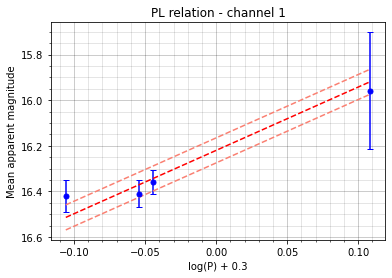

Intercept, a: 16.22
Error in a:    0.03
Std. dev.:     0.05

Distance modulus: 16.62 ± 0.04 (random) ± 0.12 (systematic)
Distance: 21.09 ± 0.42 (random) ± 1.14 (systematic) kpc




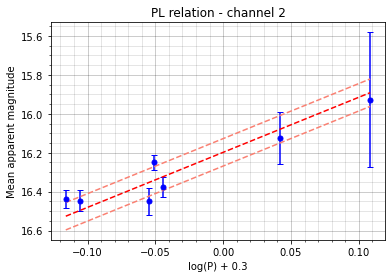

Intercept, a: 16.20
Error in a:    0.03
Std. dev.:     0.07

Distance modulus: 16.61 ± 0.04 (random) ± 0.12 (systematic)
Distance: 20.97 ± 0.40 (random) ± 1.17 (systematic) kpc


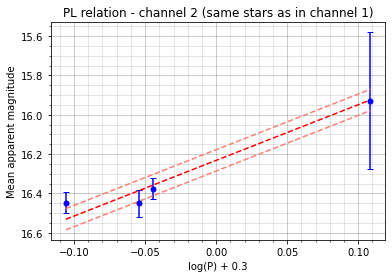

Intercept, a: 16.23
Error in a:    0.03
Std. dev.:     0.05

Distance modulus: 16.64 ± 0.04 (random) ± 0.12 (systematic)
Distance: 21.30 ± 0.42 (random) ± 1.18 (systematic) kpc


In [6]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(df_CC['period_PL'], means_ch1.mask)
periods_ch2 = np.ma.masked_array(df_CC['period_PL'], means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))

###   CHANNEL 2 PL (only stars that are also visible in channel 1)   ###

# Plotting only channel 2 stars also visible in channel 1:
means_ch2_1 = np.ma.masked_array(means_ch2, means_ch1.mask)
photerr_mean_ch2_1 = np.ma.masked_array(photerr_mean_ch2, means_ch1.mask)
stds_ch2_1 = np.ma.masked_array(stds_ch2, means_ch1.mask)
err_mean_ch2_1 = np.ma.masked_array(err_mean_ch2, means_ch1.mask)
periods_ch2_1 = np.ma.masked_array(periods_ch2, means_ch1.mask)

popt, pcov = curve_fit(PL_fit_ch2, periods_ch2_1.compressed(), means_ch2_1.compressed())
intercept_ch2_1 = popt[0]
err_int_ch2_1 = np.sqrt(pcov[0][0])

devs_ch2_1 = [(m - PL_fit_ch2(p, intercept_ch2_1))**2 for m, p in zip(means_ch2_1.compressed(), periods_ch2_1.compressed())]
std_ch2_1 = np.sqrt(np.mean(devs_ch2_1))

plt.errorbar(np.log10(periods_ch2_1.compressed()) + 0.3, means_ch2_1.compressed(), yerr=err_mean_ch2_1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1), 'r--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 + std_ch2_1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 - std_ch2_1), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2 (same stars as in channel 1)')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2_1, err_int_ch2_1, std_ch2_1))

distmod_ch2_1 = intercept_ch2_1 - a_ch2
dist_ch2_1 = 10 ** ((distmod_ch2_1 / 5.) + 1.)

distmod_randerr_ch2_1 = np.sqrt(err_int_ch2_1**2 + aerr_ch2**2)
dist_randerr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_randerr_ch2_1)

distmod_syserr_ch2_1 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_syserr_ch2_1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2_1, distmod_randerr_ch2_1, distmod_syserr_ch2_1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2_1/1000, dist_randerr_ch2_1/1000, dist_syserr_ch2_1/1000))



### Plotting PL relation (weighted fit):
Note: star in both channels on right of PL is RRL5 (RRab) - very close to another mahoosive bright star, hence the massive error bars

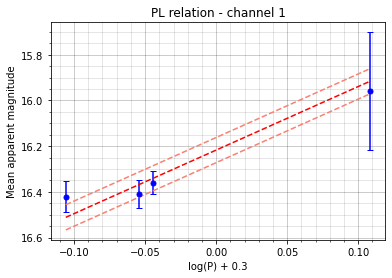

Intercept, a: 16.22
Error in a:    0.03
Std. dev.:     0.06

Distance modulus: 16.62 ± 0.04 (random) ± 0.12 (systematic)
Distance: 21.06 ± 0.41 (random) ± 1.14 (systematic) kpc




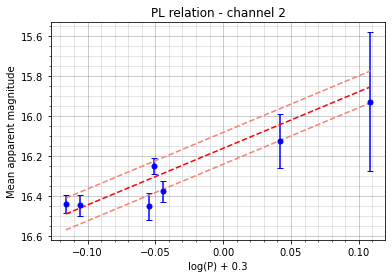

Intercept, a: 16.16
Error in a:    0.03
Std. dev.:     0.08

Distance modulus: 16.57 ± 0.04 (random) ± 0.12 (systematic)
Distance: 20.61 ± 0.39 (random) ± 1.15 (systematic) kpc


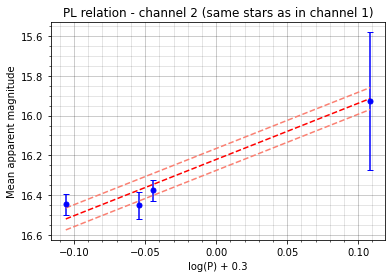

Intercept, a: 16.22
Error in a:    0.04
Std. dev.:     0.06

Distance modulus: 16.63 ± 0.05 (random) ± 0.12 (systematic)
Distance: 21.19 ± 0.45 (random) ± 1.18 (systematic) kpc


In [7]:
a_ch1 = -0.40  # Neeley 2019 intercept for absolute mag, M
a_ch2 = -0.41
b_ch1 = -2.78  # Neeley 2019 slope for PL relation
b_ch2 = -2.83

aerr_ch1 = 0.03
aerr_ch2 = 0.03
berr_ch1 = 0.38
berr_ch2 = 0.39
disp_ch1 = 0.21
disp_ch2 = 0.21

def PL_fit_ch1(P, a):  # note this a is DIFFERENT to a_ch1 above; this a is the variable being fit
    return a + b_ch1 * (np.log10(P) + 0.3)
def PL_fit_ch2(P, a):
    return a + b_ch2 * (np.log10(P) + 0.3)


means_ch1 = np.ma.masked_invalid(means_ch1)
means_ch2 = np.ma.masked_invalid(means_ch2)
photerr_mean_ch1 = np.ma.masked_array(photerr_mean_ch1, means_ch1.mask)
photerr_mean_ch2 = np.ma.masked_array(photerr_mean_ch2, means_ch2.mask)
stds_ch1 = np.ma.masked_array(stds_ch1, means_ch1.mask)
stds_ch2 = np.ma.masked_array(stds_ch2, means_ch2.mask)
A_ch1 = np.ma.masked_array(A_ch1, means_ch1.mask)
A_ch2 = np.ma.masked_array(A_ch2, means_ch2.mask)
periods_ch1 = np.ma.masked_array(df_CC['period_PL'], means_ch1.mask)
periods_ch2 = np.ma.masked_array(df_CC['period_PL'], means_ch2.mask)

err_mean_ch1 = np.sqrt(photerr_mean_ch1**2 + stds_ch1**2 + A_ch1**2)
err_mean_ch2 = np.sqrt(photerr_mean_ch2**2 + stds_ch2**2 + A_ch2**2)

###   CHANNEL 1 PL   ###

#popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed())
popt, pcov = curve_fit(PL_fit_ch1, periods_ch1.compressed(), means_ch1.compressed(), sigma=err_mean_ch1.compressed())
intercept_ch1 = popt[0]
err_int_ch1 = np.sqrt(pcov[0][0])

devs_ch1 = [(m - PL_fit_ch1(p, intercept_ch1))**2 for m, p in zip(means_ch1.compressed(), periods_ch1.compressed())]
std_ch1 = np.sqrt(np.mean(devs_ch1))

plt.errorbar(np.log10(periods_ch1.compressed()) + 0.3, means_ch1.compressed(), yerr=err_mean_ch1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1), 'r--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 + std_ch1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch1.compressed())) + 0.3, PL_fit_ch1(sorted(periods_ch1.compressed()), intercept_ch1 - std_ch1), c='salmon', ls='--')

plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 1')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch1, err_int_ch1, std_ch1))

distmod_ch1 = intercept_ch1 - a_ch1
dist_ch1 = 10 ** ((distmod_ch1 / 5.) + 1.)

distmod_randerr_ch1 = np.sqrt(err_int_ch1**2 + aerr_ch1**2)
dist_randerr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_randerr_ch1)

distmod_syserr_ch1 = np.sqrt(aerr_ch1**2 + (0.3**2 * berr_ch1**2))
dist_syserr_ch1 = abs(dist_ch1) * abs(0.2 * np.log(10.) * distmod_syserr_ch1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch1, distmod_randerr_ch1, distmod_syserr_ch1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc\n\n'.format(dist_ch1/1000, dist_randerr_ch1/1000, dist_syserr_ch1/1000))

###   CHANNEL 2 PL   ###

#popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed())
popt, pcov = curve_fit(PL_fit_ch2, periods_ch2.compressed(), means_ch2.compressed(), sigma=err_mean_ch2.compressed())
intercept_ch2 = popt[0]
err_int_ch2 = np.sqrt(pcov[0][0])

devs_ch2 = [(m - PL_fit_ch2(p, intercept_ch2))**2 for m, p in zip(means_ch2.compressed(), periods_ch2.compressed())]
std_ch2 = np.sqrt(np.mean(devs_ch2))

plt.errorbar(np.log10(periods_ch2.compressed()) + 0.3, means_ch2.compressed(), yerr=err_mean_ch2.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2), 'r--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 + std_ch2), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2.compressed()), intercept_ch2 - std_ch2), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2, err_int_ch2, std_ch2))

distmod_ch2 = intercept_ch2 - a_ch2
dist_ch2 = 10 ** ((distmod_ch2 / 5.) + 1.)

distmod_randerr_ch2 = np.sqrt(err_int_ch2**2 + aerr_ch2**2)
dist_randerr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_randerr_ch2)

distmod_syserr_ch2 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2 = abs(dist_ch2) * abs(0.2 * np.log(10.) * distmod_syserr_ch2)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2, distmod_randerr_ch2, distmod_syserr_ch2))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2/1000, dist_randerr_ch2/1000, dist_syserr_ch2/1000))

###   CHANNEL 2 PL (only stars that are also visible in channel 1)   ###

# Plotting only channel 2 stars also visible in channel 1:
means_ch2_1 = np.ma.masked_array(means_ch2, means_ch1.mask)
photerr_mean_ch2_1 = np.ma.masked_array(photerr_mean_ch2, means_ch1.mask)
stds_ch2_1 = np.ma.masked_array(stds_ch2, means_ch1.mask)
err_mean_ch2_1 = np.ma.masked_array(err_mean_ch2, means_ch1.mask)
periods_ch2_1 = np.ma.masked_array(periods_ch2, means_ch1.mask)

#popt, pcov = curve_fit(PL_fit_ch2, periods_ch2_1.compressed(), means_ch2_1.compressed())
popt, pcov = curve_fit(PL_fit_ch2, periods_ch2_1.compressed(), means_ch2_1.compressed(), sigma=err_mean_ch2_1.compressed())
intercept_ch2_1 = popt[0]
err_int_ch2_1 = np.sqrt(pcov[0][0])

devs_ch2_1 = [(m - PL_fit_ch2(p, intercept_ch2_1))**2 for m, p in zip(means_ch2_1.compressed(), periods_ch2_1.compressed())]
std_ch2_1 = np.sqrt(np.mean(devs_ch2_1))

plt.errorbar(np.log10(periods_ch2_1.compressed()) + 0.3, means_ch2_1.compressed(), yerr=err_mean_ch2_1.compressed(), fmt='o', color='blue', capsize=3, markersize=5)
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1), 'r--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 + std_ch2_1), c='salmon', ls='--')
plt.plot(np.log10(sorted(periods_ch2_1.compressed())) + 0.3, PL_fit_ch2(sorted(periods_ch2_1.compressed()), intercept_ch2_1 - std_ch2_1), c='salmon', ls='--')
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gca().invert_yaxis()
plt.xlabel('log(P) + 0.3')
plt.ylabel('Mean apparent magnitude')
plt.title('PL relation - channel 2 (same stars as in channel 1)')
plt.show()
print('Intercept, a: {0:.2f}\nError in a:    {1:.2f}\nStd. dev.:     {2:.2f}\n'.format(intercept_ch2_1, err_int_ch2_1, std_ch2_1))

distmod_ch2_1 = intercept_ch2_1 - a_ch2
dist_ch2_1 = 10 ** ((distmod_ch2_1 / 5.) + 1.)

distmod_randerr_ch2_1 = np.sqrt(err_int_ch2_1**2 + aerr_ch2**2)
dist_randerr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_randerr_ch2_1)

distmod_syserr_ch2_1 = np.sqrt(aerr_ch2**2 + (0.3**2 * berr_ch2**2))
dist_syserr_ch2_1 = abs(dist_ch2_1) * abs(0.2 * np.log(10.) * distmod_syserr_ch2_1)  # 0.3^2 from PL equation

print('Distance modulus: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic)'.format(distmod_ch2_1, distmod_randerr_ch2_1, distmod_syserr_ch2_1))
print('Distance: {0:.2f} ± {1:.2f} (random) ± {2:.2f} (systematic) kpc'.format(dist_ch2_1/1000, dist_randerr_ch2_1/1000, dist_syserr_ch2_1/1000))



#### Trying to get matching to master list based on coordinates working (but it won't and i am sad):
These aren't used any more but I'm keeping them around in case I need them

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL2_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
        1 10.402177 34.836456 229.05098 -0.16560569
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1343.18787331), array(75.13551432))


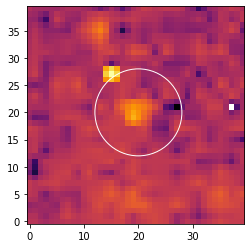

Mean: 55.818267822265625
Median: 53.148773193359375
Std dev: 21.55946159362793
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.227896598568737 ... 3.6291534039851086 -1.3995133154422503
  2 12.724013992464322 ... 1.6044276340321735 -0.5133003337295393
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


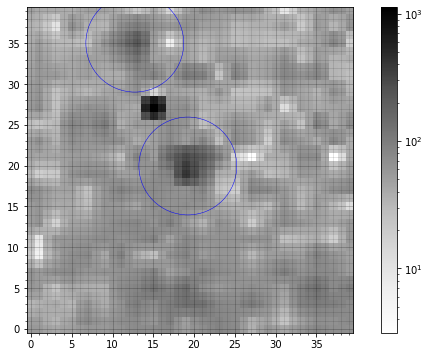

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.227897 19.956908 0.53458902 ... 357.69717 3.6291534  -1.3995133        1
  2 12.724014 35.022011 0.78328236 ... 218.59438 1.6044276 -0.51330033        2


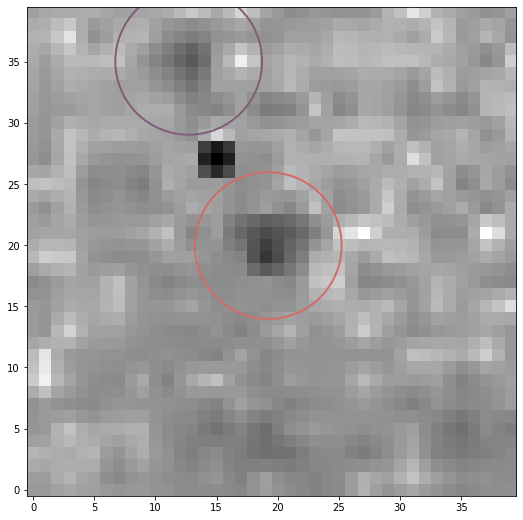

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.10932639999998628s
   x_0       y_0     flux_0   id ...   y_fit    flux_fit  flux_unc iter_detected
--------- --------- -------- --- ... --------- --------- --------- -------------
19.227897 19.956908 4822.526   1 ... 19.956908 4382.3119 123.23011             1
12.724014 35.022011 1350.585   2 ... 35.022011   1767.19 86.806252             1


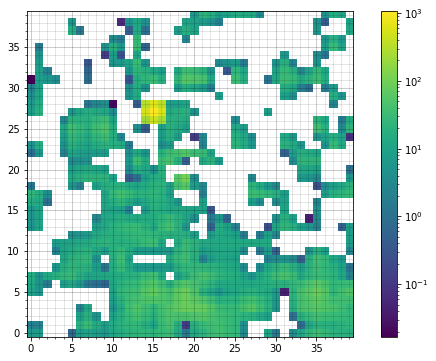

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.227897 19.956908    16.448818 0.042486303
  2        2             1 12.724014 35.022011    17.434868 0.060969787
first match table:
 id  xcenter   ycenter    mag_e1     err_e1  
--- --------- --------- --------- -----------
  1 19.227897 19.956908 16.448818 0.042486303
  2 12.724014 35.022011 17.434868 0.060969787
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05319478, -0.16745755), (229.0508948 , -0.16597776)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
[0 1] [0d00m01.0045s 0d00m01.3741s] [4.87003741e-06 6.66196011e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0  17.55115    19.992 229.05323 -0.16718075
       

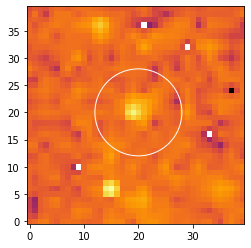

Mean: 48.83451843261719
Median: 46.608665466308594
Std dev: 19.045347213745117
yay all conditions check out
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
sources_PSF:   id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 19.255514556692503 ... 4.4391054446582645 -1.6182386529944484
  2  12.84202304717548 ...  1.995459294666297 -0.7501071826151671
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


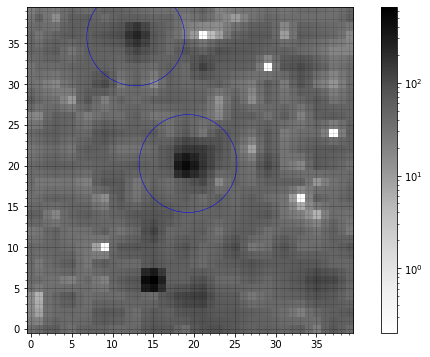

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.255515 20.258677 0.91022835 ... 500.10239 4.4391054  -1.6182387        1
  2 12.842023  35.79453 0.85214092 ... 237.62831 1.9954593 -0.75010718        2


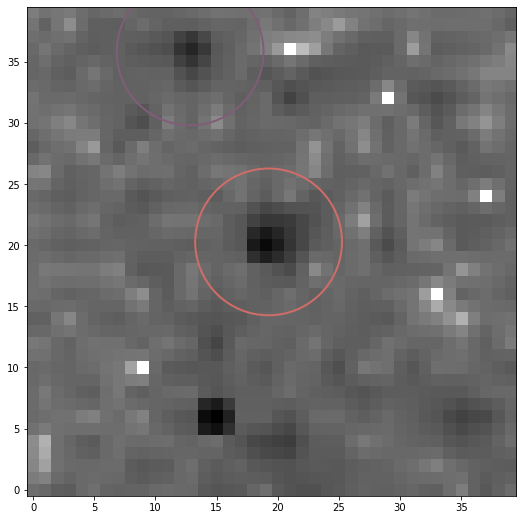

Time taken to fit PSF model: 0.029739500000005137s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.255515 20.258677 4008.3319   1 ... 4498.2229 119.32239             1
12.842023  35.79453  1651.618   2 ...  1964.124 73.524306             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


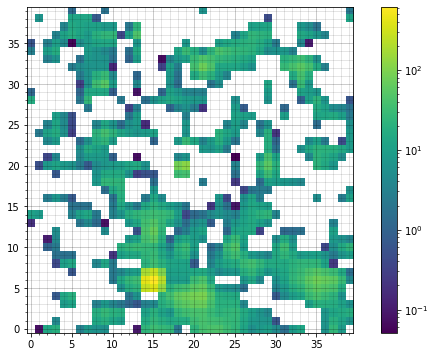

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.255515 20.258677    16.420101 0.041260712
  2        2             1 12.842023  35.79453    17.319781 0.050247543
first match table:
 id  xcenter   ycenter    mag_e2     err_e2  
--- --------- --------- --------- -----------
  1 19.255515 20.258677 16.420101 0.041260712
  2 12.842023  35.79453 17.319781 0.050247543
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05314435, -0.16745388), (229.05076385, -0.16597719)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
[0 1] [0d00m01.0305s 0d00m01.5473s] [4.99592472e-06 7.50156143e-06]
comp @ idx:
[0 1]
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0  17.5

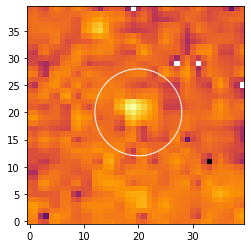

Mean: 47.087528228759766
Median: 44.870487213134766
Std dev: 20.56047248840332
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
sources_PSF:   id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  19.93869266177346 ... 1.1223069973790027 -0.12527917668256655
  2 19.050473480767664 ...  4.143650081746444   -1.543457683696798
Number of PSF stars: 2


C:\Users\Jake\anaconda3\lib\site-packages\astropy\table\table.py:3075: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


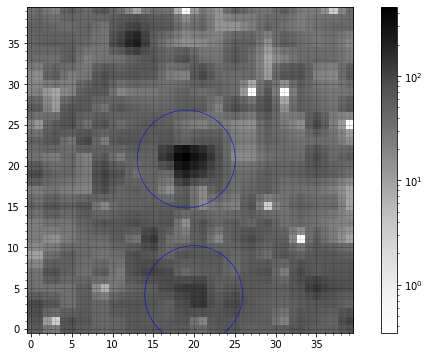

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 19.938693 4.1834707 0.36345366 ... 118.67358  1.122307 -0.12527918        1
  2 19.050473   20.8107 0.79079518 ... 463.30774 4.1436501  -1.5434577        2


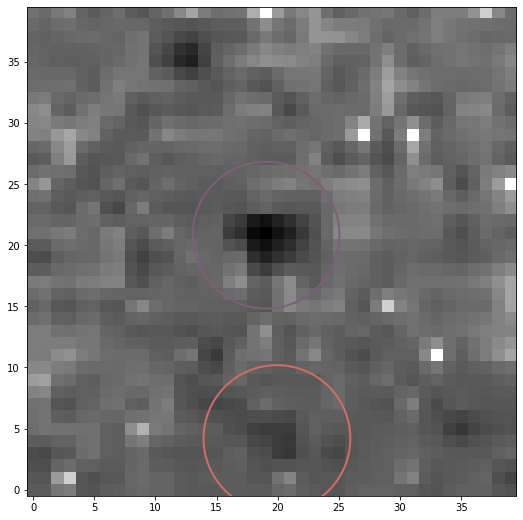

Time taken to fit PSF model: 0.03251090000003387s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
19.938693 4.1834707 2811.1269   1 ...  1525.146 114.99214             1
19.050473   20.8107 4252.8996   2 ... 4768.3704 126.55147             1


C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


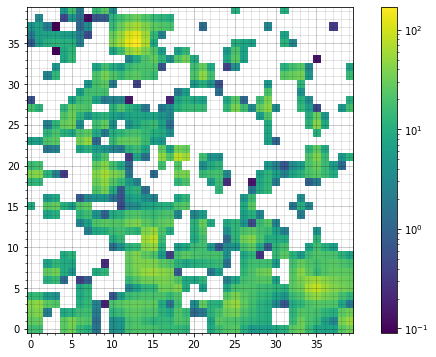

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 19.938693 4.1834707     17.59489 0.087030485
  2        2             1 19.050473   20.8107    16.357244 0.041270727
first match table:
 id  xcenter   ycenter    mag_e3     err_e3  
--- --------- --------- --------- -----------
  1 19.938693 4.1834707  17.59489 0.087030485
  2 19.050473   20.8107 16.357244 0.041270727
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05576938, -0.16800199), (229.05305908, -0.16740521)]>
<SkyCoord (ICRS): (ra, dec) in deg
    [(229.05323, -0.16718075), (229.05098, -0.16560569)]>
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
[0 0] [0d00m09.6079s 0d00m01.0156s] [4.65803724e-05 4.92396538e-06]
comp @ idx:
[0 0]
id_master   x_0     y_0       RA    ...    err_e1     mag_e2     err_e2  
--------- -------- ------ --------- ... ----------- --------- -----------
        0 17.55

IndexError: index -99 is out of bounds for axis 0 with size 2

In [9]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
        
        star = 2
        
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')
        print_table_nicely(master_table)
    
        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2 and epoch == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi=0.95)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                #sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi_PSF)
                
                print('sources_PSF: ', sources_PSF)
                if sources_PSF == None:
                    print('no sources found :(')                
                
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                if ncolors > 1:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color=cmap.colors[i], lw=2.)
                else:
                    for i, group in enumerate(star_groups.groups):
                        pos_group = np.transpose([group['x_0'], group['y_0']])
                        ap_group = CircularAperture(pos_group, r_ap)
                        ap_group.plot(color='blue', lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                
                print('first match table:')
                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###

            true_x = pix_crd[0]+match_table['xcenter']-star_r
            true_y = pix_crd[1]+match_table['ycenter']-star_r
            cat_match, ra, dec = make_catalog(true_x, true_y, hdr)
            match_table['RA'] = ra
            match_table['dec'] = dec

            comp_table = copy.copy(master_table)
            cat_m = SkyCoord(comp_table['RA'], comp_table['dec'], frame='icrs', unit='deg')

            print(cat_match)
            print(cat_m)

            idx, d2d, d3d = cat_match.match_to_catalog_sky(cat_m)
            idx2, d2d2, d3d2 = match_coordinates_sky(cat_match, cat_m)
            
            print(idx, d2d, d3d)
            print(idx2, d2d2, d3d2)
            
            print('comp @ idx:')
            print(idx)
            print(comp_table[idx])

            # Selection criteria:
            max_sep = 0.001 * u.degree
            selection = (d2d > max_sep)
            match_index = idx
            match_index[selection] = -99
            ind = ((match_index >= 0))  # keeps only positive indices (ie. removes -99s)

            print(ind, match_index)

            print('\n\n')
            print_table_nicely(match_table)
            print_table_nicely(comp_table)
            print('\n\n')

            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            
            print(match_table)
            print(comp_table)
            print('match length:', len(match_table))
            print('comp length: ', len(comp_table))
            match_table = match_table[ind]
            comp_table = comp_table[match_index][ind]

            match_table['id_master'] = comp_table['id_master']

            match_table = Table(match_table, masked=True)

            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)

            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        '''save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close()'''


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###

Photometry method selected: PSF
outputs/PAL5/masterlist_RRL0_3p6um.txt
id_master    x_0       y_0        RA        dec    
--------- --------- --------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946
        1  23.78174 2.2946799 228.99106 -0.11590368
        2 19.035947 17.895987 228.98862 -0.11470356
        3 28.339118 3.5178503 228.99074 -0.11662042
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
(array(1094.44146707), array(511.14364631))


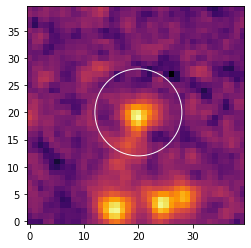

Mean: 51.14960861206055
Median: 45.8643913269043
Std dev: 20.52968978881836
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.575564766899848 ...  3.229357000877366 -1.2727901457891397
  2 24.468016488625913 ... 2.6370181380326754 -1.0527827924589486
  3 19.840980613332604 ... 3.0119700744567304 -1.1971266315018754
Number of PSF stars: 3


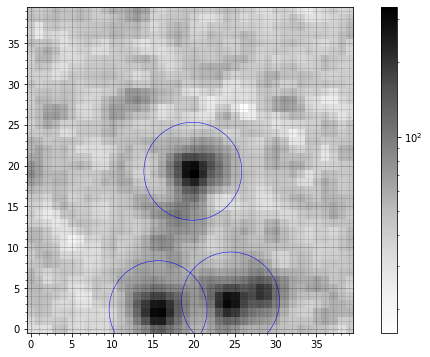

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.575565 2.3412497  0.5500007 ... 313.79651  3.229357 -1.2727901        1
  2 24.468016 3.4122953 0.66038248 ... 308.46622 2.6370181 -1.0527828        1
  3 19.840981 19.312539 0.66081841 ... 335.77524 3.0119701 -1.1971266        2


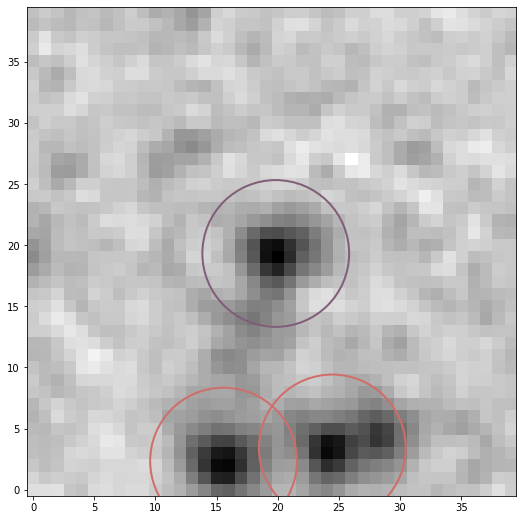

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13006529999984195s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.575565 2.3412497  5234.599   1 ... 4282.3508 158.62785             1
24.468016 3.4122953 6343.6234   2 ... 4203.3857 159.67692             1
19.840981 19.312539 5035.5648   3 ... 4349.1952 97.013214             1
28.818834 4.6227482 1987.8664   4 ... 1950.2446 69.134211             2


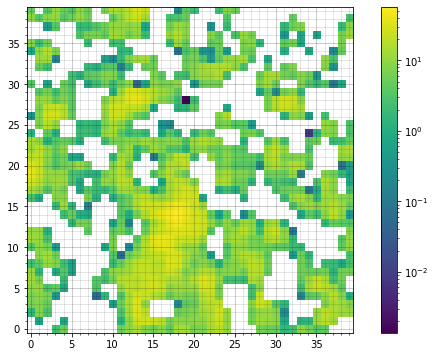

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.575565 2.3412497    16.481396 0.049904437
  2        1             1 24.468016 3.4122953    16.501604 0.050735348
  3        2             1 19.840981 19.312539     16.46458 0.038203282
  4        1             2 28.818834 4.6227482    17.335379 0.048521165
 id  xcenter   ycenter    mag_e1     err_e1   id_master
--- --------- --------- --------- ----------- ---------
  1 15.575565 2.3412497 16.481396 0.049904437         0
  2 24.468016 3.4122953 16.501604 0.050735348         1
  3 19.840981 19.312539  16.46458 0.038203282         2
  4 28.818834 4.6227482 17.335379 0.048521165         3
id_master    x_0       y_0        RA        dec       mag_e1     err_e1  
--------- --------- --------- --------- ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 -0.11445946 16.481396 0.049904437
        1 

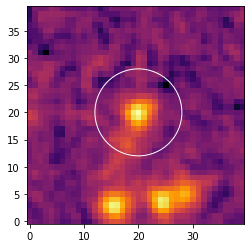

Mean: 45.08599090576172
Median: 39.76604461669922
Std dev: 21.78135871887207
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.529851137079332 ... 2.8684341330745937 -1.1441122044230256
  2 24.588323791199468 ...  2.521756212073415 -1.0042577483475987
  3 19.895611595859556 ... 3.2725228838763614 -1.2872067303461203
Number of PSF stars: 3


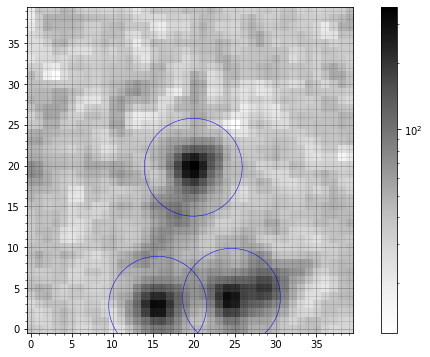

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.529851 2.8852351  0.6115023 ...  317.5033 2.8684341 -1.1441122        1
  2 24.588324 3.8501471 0.64750822 ... 305.72614 2.5217562 -1.0042577        1
  3 19.895612  19.80354 0.63817235 ... 359.59317 3.2725229 -1.2872067        2


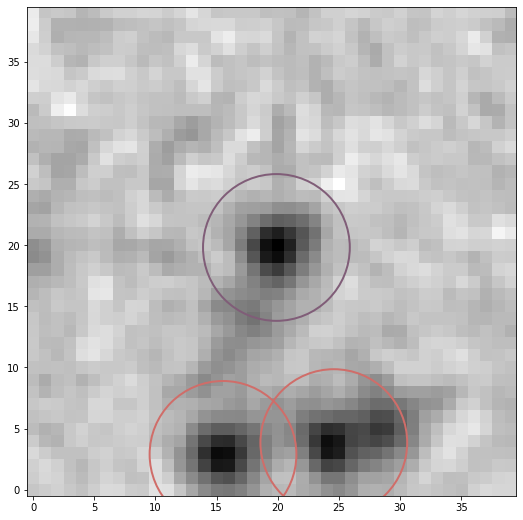

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.05155899999954272s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.529851 2.8852351 4907.8212   1 ...  3888.027 149.42427             1
24.588324 3.8501471 6495.5983   2 ... 4029.7415 151.86088             1
19.895612  19.80354 5290.4631   3 ...  4546.161 96.792641             1
28.991484 5.2863925 2094.5302   4 ...  2008.288 91.399826             2


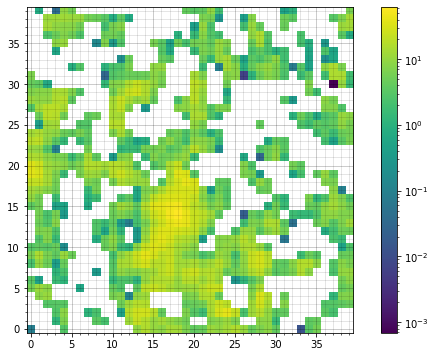

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.529851 2.8852351    16.585697 0.051128195
  2        1             1 24.588324 3.8501471    16.546827  0.05046856
  3        2             1 19.895612  19.80354    16.415908 0.037514391
  4        1             2 28.991484 5.2863925    17.302955 0.057572822
 id  xcenter   ycenter    mag_e2     err_e2   id_master
--- --------- --------- --------- ----------- ---------
  1 15.529851 2.8852351 16.585697 0.051128195         0
  2 24.588324 3.8501471 16.546827  0.05046856         1
  3 19.895612  19.80354 16.415908 0.037514391         2
  4 28.991484 5.2863925 17.302955 0.057572822         3
id_master    x_0       y_0        RA    ...    err_e1     mag_e2     err_e2  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049904437 16.585697 0.05112819

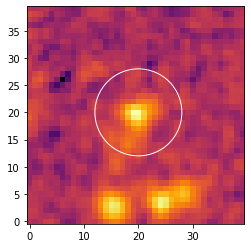

Mean: 43.298133850097656
Median: 38.060081481933594
Std dev: 21.694374084472656
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.324348926937843 ...  2.740425138283709  -1.094544856766432
  2 24.356835138718903 ...  2.714869883759798 -1.0843725497115577
  3  19.62447740837231 ... 3.2168555396751186 -1.2685788958587219
Number of PSF stars: 3


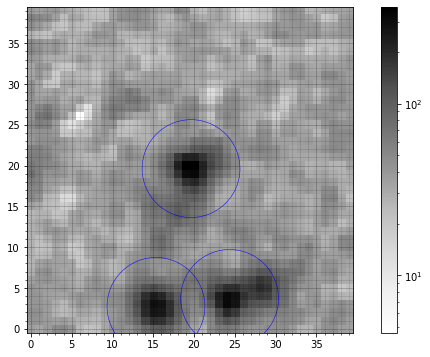

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.324349 2.7371235  0.5340575 ... 289.66589 2.7404251 -1.0945449        1
  2 24.356835 3.7104366 0.65278165 ... 315.94113 2.7148699 -1.0843725        1
  3 19.624477  19.63687  0.6275326 ... 355.89859 3.2168555 -1.2685789        2


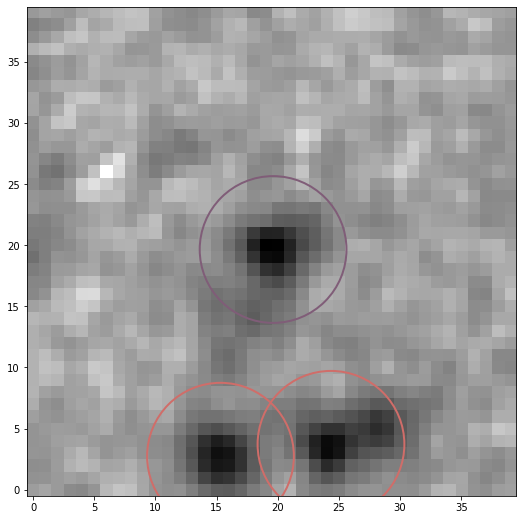

Time taken to fit PSF model: 0.05036079999990761s

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)



   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.324349 2.7371235 4992.7411   1 ... 4055.7058 150.07603             1
24.356835 3.7104366  6316.759   2 ... 4313.4969 150.60356             1
19.624477  19.63687 5878.2963   3 ... 4946.7007 89.934214             1
28.912678 5.2484861 2236.2822   4 ... 2001.7659 81.189482             2


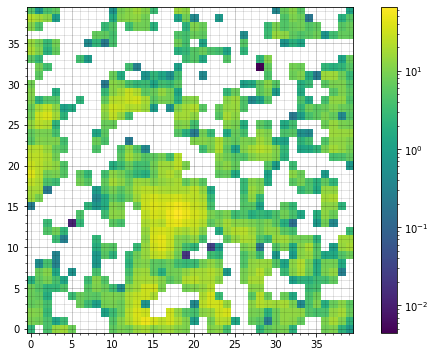

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.324349 2.7371235    16.540501 0.049870705
  2        1             1 24.356835 3.7104366    16.473594 0.048062134
  3        2             1 19.624477  19.63687    16.324878 0.035533096
  4        1             2 28.912678 5.2484861    17.307134 0.053029737
 id  xcenter   ycenter    mag_e3     err_e3   id_master
--- --------- --------- --------- ----------- ---------
  1 15.324349 2.7371235 16.540501 0.049870705         0
  2 24.356835 3.7104366 16.473594 0.048062134         1
  3 19.624477  19.63687 16.324878 0.035533096         2
  4 28.912678 5.2484861 17.307134 0.053029737         3
id_master    x_0       y_0        RA    ...    err_e2     mag_e3     err_e3  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.051128195 16.540501 0.04987070

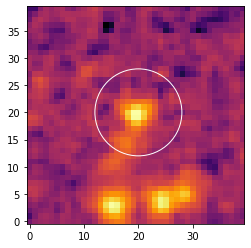

Mean: 41.48185729980469
Median: 36.60084533691406
Std dev: 21.256439208984375
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.402103064215103 ...  2.940967477508381 -1.1712255547930523
  2 24.441040130497164 ... 2.5445886987166184 -1.0140439850382048
  3 19.584984056330125 ...  3.317834368858013 -1.3021367540351565
Number of PSF stars: 3


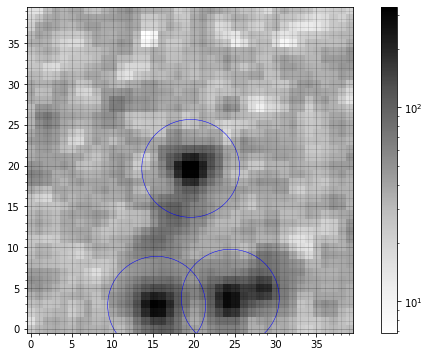

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.402103 2.8725598 0.62275623 ... 325.81424 2.9409675 -1.1712256        1
  2  24.44104 3.7414083 0.61550877 ... 291.70139 2.5445887  -1.014044        1
  3 19.584984 19.661793 0.57186691 ... 331.10718 3.3178344 -1.3021368        2


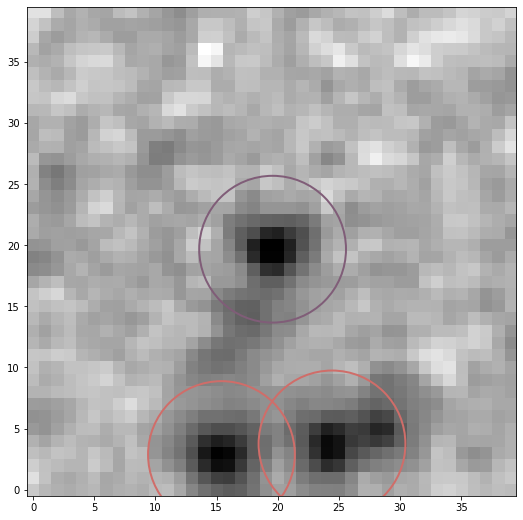

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.13611569999920903s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.402103 2.8725598 5329.7702   1 ... 4051.8584 141.20479             1
 24.44104 3.7414083 6082.0895   2 ... 4012.1419 146.73186             1
19.584984 19.661793 5237.4321   3 ... 4606.1036 84.637918             1
28.863052 5.1782517 1945.5198   4 ... 1840.7738  83.87635             2


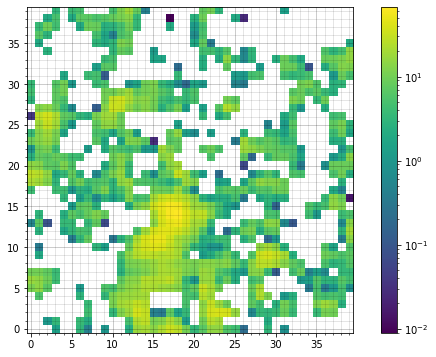

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.402103 2.8725598    16.541081 0.048006401
  2        1             1  24.44104 3.7414083    16.551776 0.049493862
  3        2             1 19.584984 19.661793    16.401882 0.035650853
  4        1             2 28.863052 5.1782517    17.397715 0.057623613
 id  xcenter   ycenter    mag_e4     err_e4   id_master
--- --------- --------- --------- ----------- ---------
  1 15.402103 2.8725598 16.541081 0.048006401         0
  2  24.44104 3.7414083 16.551776 0.049493862         1
  3 19.584984 19.661793 16.401882 0.035650853         2
  4 28.863052 5.1782517 17.397715 0.057623613         3
id_master    x_0       y_0        RA    ...    err_e3     mag_e4     err_e4  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.049870705 16.541081 0.04800640

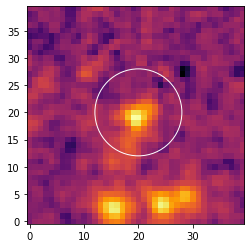

Mean: 41.5771484375
Median: 36.40973663330078
Std dev: 20.748353958129883
 id     xcentroid     ...        flux               mag         
--- ----------------- ... ----------------- --------------------
  1 15.41594560840494 ... 3.177380045210075  -1.2551729093265562
  2 24.46245075408594 ... 2.722809928717321   -1.087543313972069
  3 28.03162586417031 ... 1.344736198500567 -0.32159273915026876
  4 19.64046228737398 ... 3.441693502329084  -1.3419304797856226
Number of PSF stars: 4


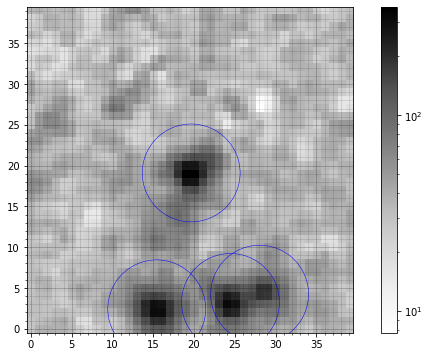

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.415946 2.4431413 0.54827609 ...  302.9071   3.17738  -1.2551729        1
  2 24.462451 3.2251417 0.69369881 ... 313.86978 2.7228099  -1.0875433        1
  3 28.031626 4.2359861 0.67056078 ... 186.96165 1.3447362 -0.32159274        1
  4 19.640462 19.105593  0.6297486 ... 353.34238 3.4416935  -1.3419305        2


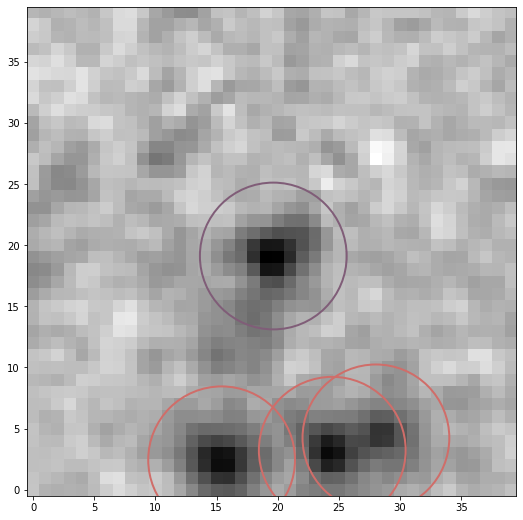

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.04051690000051167s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.415946 2.4431413 5087.0391   1 ... 4361.4582 93.197894             1
24.462451 3.2251417 6117.9363   2 ... 3480.1308 89.643748             1
28.031626 4.2359861 5933.2528   3 ... 1937.2708 95.931724             1
19.640462 19.105593 5364.6779   4 ... 4337.1694 89.390413             1


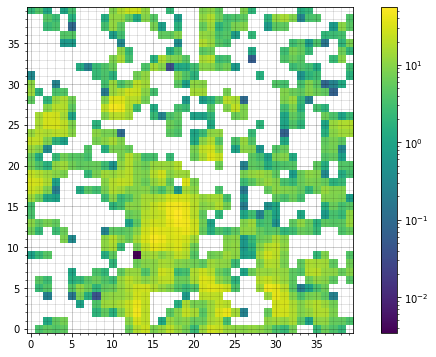

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.415946 2.4431413    16.461172 0.037566263
  2        1             1 24.462451 3.2251417    16.706262 0.040683178
  3        1             1 28.031626 4.2359861    17.342275 0.061348083
  4        2             1 19.640462 19.105593    16.467235 0.037063511
 id  xcenter   ycenter    mag_e5     err_e5   id_master
--- --------- --------- --------- ----------- ---------
  1 15.415946 2.4431413 16.461172 0.037566263         0
  2 24.462451 3.2251417 16.706262 0.040683178         1
  3 28.031626 4.2359861 17.342275 0.061348083         2
  4 19.640462 19.105593 16.467235 0.037063511         3
id_master    x_0       y_0        RA    ...    err_e4     mag_e5     err_e5  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.048006401 16.461172 0.03756626

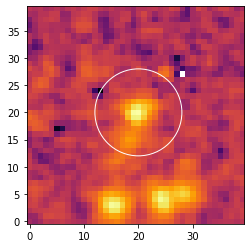

Mean: 34.465213775634766
Median: 28.9788818359375
Std dev: 21.482254028320312
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.434755562019973 ...  2.738553859224638 -1.0938032165799807
  2 24.534598456523725 ... 2.4849501718563496 -0.9882942117430025
  3  19.74102929173598 ... 3.1529990801217895 -1.2468096101094626
Number of PSF stars: 3


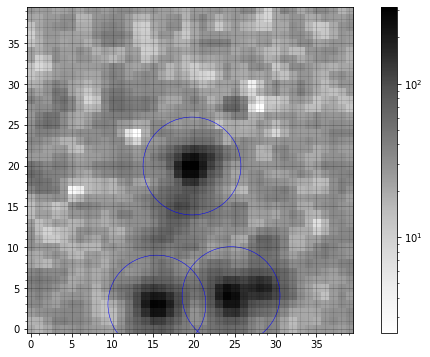

 id    x_0       y_0    sharpness  ...    peak      flux       mag     group_id
--- --------- --------- ---------- ... --------- --------- ----------- --------
  1 15.434756 3.0174515 0.61955722 ... 295.59125 2.7385539  -1.0938032        1
  2 24.534598 4.0607341 0.64556602 ... 289.43369 2.4849502 -0.98829421        1
  3 19.741029 19.956366 0.59445665 ... 317.62701 3.1529991  -1.2468096        2


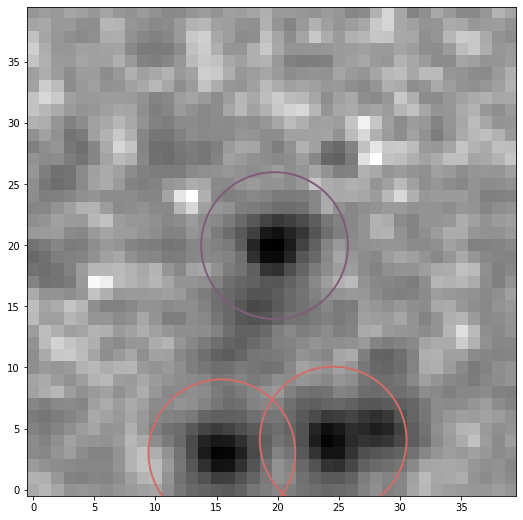

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.053249399999913294s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.434756 3.0174515 4753.6891   1 ... 3652.2488 138.09474             1
24.534598 4.0607341 6293.5869   2 ... 3843.2674 138.94848             1
19.741029 19.956366 5310.5515   3 ... 4089.3208 104.98822             1
28.973933 5.1364362 2135.1223   4 ...  1802.625 89.064865             2


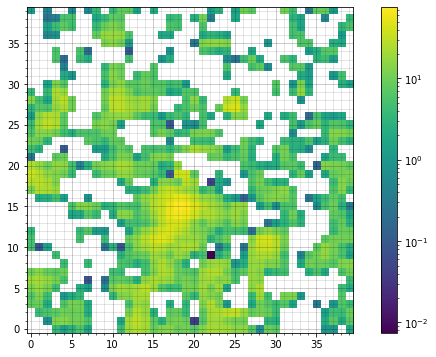

 id group_id iter_detected   x_fit     y_fit   apparent_mag   mag_err  
--- -------- ------------- --------- --------- ------------ -----------
  1        1             1 15.434756 3.0174515    16.653923 0.050579411
  2        1             1 24.534598 4.0607341    16.598573 0.049130323
  3        2             1 19.741029 19.956366    16.531196  0.04061981
  4        1             2 28.973933 5.1364362    17.420561 0.061242892
 id  xcenter   ycenter    mag_e6     err_e6   id_master
--- --------- --------- --------- ----------- ---------
  1 15.434756 3.0174515 16.653923 0.050579411         0
  2 24.534598 4.0607341 16.598573 0.049130323         1
  3 19.741029 19.956366 16.531196  0.04061981         2
  4 28.973933 5.1364362 17.420561 0.061242892         3
id_master    x_0       y_0        RA    ...    err_e5     mag_e6     err_e6  
--------- --------- --------- --------- ... ----------- --------- -----------
        0 14.856317 1.4061623 228.99145 ... 0.037566263 16.653923 0.05057941

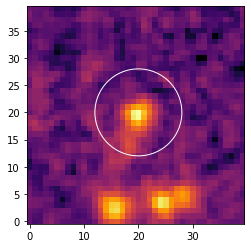

Mean: 44.564720153808594
Median: 39.59773254394531
Std dev: 20.280550003051758
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1 15.564749020605866 ... 2.9685813322824215 -1.1813723802308034
  2 24.521924645846568 ...  2.701261719771453 -1.0789166603446532
  3    19.834005774293 ...  3.475327996429202 -1.3524894973636068
Number of PSF stars: 3


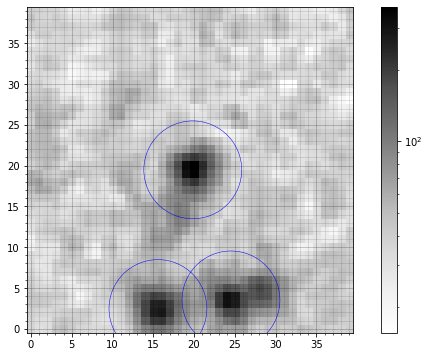

 id    x_0       y_0    sharpness  ...    peak      flux      mag     group_id
--- --------- --------- ---------- ... --------- --------- ---------- --------
  1 15.564749 2.4744354  0.5221548 ... 280.71216 2.9685813 -1.1813724        1
  2 24.521925 3.5346052 0.66508775 ... 305.35577 2.7012617 -1.0789167        1
  3 19.834006 19.485999 0.67392894 ... 367.90244  3.475328 -1.3524895        2


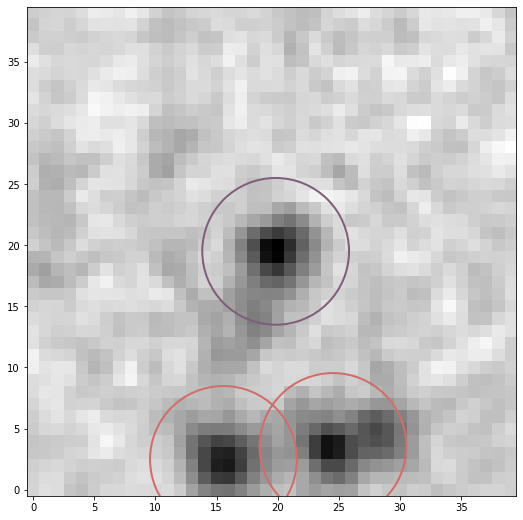

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


Time taken to fit PSF model: 0.11658429999806685s
   x_0       y_0      flux_0   id ...  flux_fit  flux_unc iter_detected
--------- --------- --------- --- ... --------- --------- -------------
15.564749 2.4744354 4970.8549   1 ... 4167.3416 152.34688             1
24.521925 3.5346052 6218.9892   2 ... 4314.5054 151.11573             1
19.834006 19.485999 5261.3001   3 ... 4973.3311  114.0385             1
28.882514  4.655196 1819.9378   4 ... 1733.0658 75.841961             2


KeyboardInterrupt: 

In [145]:
print('Photometry method selected: {}'.format(method))

epsf_file = 'epsf_models/'+cluster+'/epsf_'+channel+'_'+str(model_epoch)+'.pickle'
pickle_in = open(epsf_file, 'rb')
epsf = pickle.load(pickle_in)

file_CC = 'data/reference/CVSGC_'+cluster+'_readable.txt'
tbl_CC = Table.read(file_CC, format='ascii.csv')

for star in range(len(tbl_CC)):
    
    if star in starlist:
    
        master_file = 'outputs/'+cluster+'/masterlist_RRL'+str(star)+'_'+channel+'.txt'
        print(master_file)
        master_table = Table.read(master_file, format='ascii.csv')

        print_table_nicely(master_table)

        LC_time = []

        star_ra = tbl_CC['RA'][star]
        star_dec = tbl_CC['dec'][star]
        star_crd = SkyCoord(star_ra, star_dec, frame='icrs', unit='deg')

        epoch = 1  # counter to be incremented every epoch

        for filename in glob.glob(base_dir+'*/'+cluster+'__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/'+cluster+'__e[0-9][0-9]_'+channel+'.fits', recursive=True):

            ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###

            with fits.open(filename) as hdu_list:        
                print(filename)
                image_data = hdu_list[0].data
                hdr = hdu_list[0].header
                exptime = hdr['EXPTIME']
                fluxconv = hdr['FLUXCONV']
                conv = exptime / fluxconv
                print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
                data = image_data * conv

            LC_time.append(Time(hdr['DATE_OBS'], format='isot', scale='utc').mjd)

            file_corr = base_dir+'PAL5__e'+str(epoch)+'/'+cluster+'__e'+str(epoch)+'_correction_'+channel+'.fits'
            with fits.open(file_corr) as hdu_list:
                data_corr = hdu_list[0].data       

            w = wcs.WCS(hdr)
            pix_crd = w.world_to_pixel(star_crd)
            print(pix_crd)

            star_x = int(pix_crd[0])
            star_y = int(pix_crd[1])
            star_ap = CircularAperture((star_r, star_r), r=8.)
            region = data[star_y-star_r:star_y+star_r, star_x-star_r:star_x+star_r]
            plt.imshow(region, cmap='inferno', origin='lower', norm=LogNorm(), interpolation='nearest', aspect='equal')
            star_ap.plot(color='white')
            plt.show()

            mean, median, std = sigma_clipped_stats(region, sigma=sigma_level)
            print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))

            if method == 'aperture':

                ###   LOCATING STARS AND PLOTTING THEM   ###
                # could maybe put most of this in its own starfind function? including aperture and position bits

                sources = star_find(region, sigma_level, FWHM, std, roundness, sharphi)
                print(sources)
                pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
                apertures = CircularAperture(pos, r_ap)
                annuli = CircularAnnulus(pos, r_in, r_out)
                print('No. of stars detected: {0}'.format(len(sources)))
                plotting(region, apertures, annuli, 'Greys', choice='both_aps', savename=None)

                ###   DOING APERTURE PHOTOMETRY   ###

                phot_table = ap_phot(region, apertures, annuli, 'median')
                print_table_nicely(phot_table)

                phot_table['apparent_mag'] = float('NaN')
                phot_table['mag_err'] = float('NaN')
                for i in range(len(phot_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if phot_table['star_bkgsub'][i] >= 0:
                        phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                        phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)

                print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(phot_table)
                del match_table['aperture_sum_0', 'aperture_sum_1', 'bkg_sum_median', 'star_bkgsub', 'counts_err']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)


            if method == 'PSF':

                ###   DETECTING MORE STARS   ###
                
                if cluster == 'PAL5' and channel == '3p6um' and star == 2:  # special conditions for a special star
                    print('yay all conditions check out')
                    sources_PSF = star_find(region, sigma_level-2, FWHM, std, roundness, sharphi=1.)
                else:
                    sources_PSF = star_find(region, sigma_level, FWHM, std, roundness, sharphi_PSF)
                    
                print(sources_PSF)
                pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
                ap_PSF = CircularAperture(pos_PSF, r_ap)
                print('Number of PSF stars: {}'.format(len(sources_PSF)))
                plotting(region, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename=None)

                ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###

                sources_PSF['xcentroid'].name = 'x_0'
                sources_PSF['ycentroid'].name = 'y_0'
                daogroup = DAOGroup(crit_separation=2.5*FWHM)
                #daogroup = DAOGroup(crit_separation=4*FWHM)
                star_groups = daogroup(sources_PSF)
                star_groups = star_groups.group_by('group_id')
                print_table_nicely(star_groups)

                ncolors = max(star_groups['group_id'])
                cmap = make_random_cmap(ncolors=ncolors, seed=1612)
                plt.imshow(region, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
                for i, group in enumerate(star_groups.groups):
                    pos_group = np.transpose([group['x_0'], group['y_0']])
                    ap_group = CircularAperture(pos_group, r_ap)
                    ap_group.plot(color=cmap.colors[i], lw=2.)
                plt.gcf().set_size_inches(15, 9)
                plt.show()

                ###   DOING PSF PHOTOMETRY   ###

                region_nonans = np.nan_to_num(region, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash

                #bkg_estimation = MMMBackground()
                #fitter = LevMarLSQFitter()
                daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=sharphi_PSF)
                fit_rad = 5

                epsf.x_0.fixed = True
                epsf.y_0.fixed = True
                init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
                #init_pos = Table(names=['x_0', 'y_0'], data=transf_list)

                start = time.perf_counter()
                PSF_photometry = ISPSF(finder = daofind_PSF,
                                      group_maker = daogroup,
                                      bkg_estimator = MMMBackground(),
                                      psf_model = epsf,
                                      fitter = LevMarLSQFitter(),
                                      fitshape = 2*fit_rad+1,
                                      niters = 2,
                                      aperture_radius = 6.)
                PSF_table = PSF_photometry(image=region_nonans, init_guesses=init_pos)
                residual_image = PSF_photometry.get_residual_image()
                print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))

                for i in range(len(PSF_table)):
                    if PSF_table['iter_detected'][i] > 1:
                        PSF_table['id'][i] += max(PSF_table['id'])

                print_table_nicely(PSF_table)

                plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)

                hdu = fits.PrimaryHDU(residual_image)
                hdul = fits.HDUList([hdu])
                hdul.writeto('outputs/'+cluster+'/residuals/star'+str(star+1)+'_e'+str(epoch)+'_residual.fits', overwrite=True)

                PSF_table['apparent_mag'] = float('NaN')
                PSF_table['mag_err'] = float('NaN')
                for i in range(len(PSF_table)):
                    locorr = data_corr[int(pix_crd[1])][int(pix_crd[0])]  # location-dependent correction at star's location

                    if PSF_table['flux_fit'][i] >= 0:
                        PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                        PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)


                print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])

                match_table = copy.copy(PSF_table)
                del match_table['x_0', 'y_0', 'flux_0', 'flux_fit', 'flux_unc', 'iter_detected', 'group_id']
                mag_name = 'mag_e'+str(epoch)
                err_name = 'err_e'+str(epoch)
                match_table.rename_column('apparent_mag', mag_name)
                match_table.rename_column('mag_err', err_name)
                match_table.rename_column('x_fit', 'xcenter')
                match_table.rename_column('y_fit', 'ycenter')
                match_table['id_master'] = master_table['id_master']

                print_table_nicely(match_table)

                ###   END OF PSF SECTION   ###


            # This approach relies on the same stars being detected in the same order in each epoch, which isn't ideal:
            master_table = join(master_table, match_table['id_master', mag_name, err_name], keys='id_master', join_type='left')
            print_table_nicely(master_table)


            if run_all == False:
                break

            epoch += 1
            print('\n\n\n')

            ###   END OF EPOCH LOOP   ###


        master_crd = SkyCoord(master_table['RA'], master_table['dec'], frame='icrs', unit='deg')
        print(master_crd)
        print(star_crd)
        star_id, d2d, d3d = star_crd.match_to_catalog_sky(master_crd)
        print('Star ID: ', star_id)
        print(master_table[star_id])

        save_name = 'phot_tables/'+cluster+'/individual/big_table_RRL'+str(star)+'_'+method+'_'+channel+'.pickle'
        pickle_out = open(save_name, 'wb')
        pickle.dump(master_table[star_id], pickle_out)
        pickle_out.close() 


        print('\n\n')

        #break
        
        ###   END OF IF IN STARLIST CHECK   ###
    
    ###   END OF STAR LOOP   ###